In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
import scipy.stats as st

In [2]:
data = pd.read_parquet('data/transaction_fraud_data.parquet')
data_currency = pd.read_parquet('data/historical_currency_exchange.parquet')

Перейдём к долларам

In [3]:
data['date'] = data['timestamp'].dt.date

In [4]:
temp_df = data.merge(data_currency, on='date', how='left')
temp_df['amount_usd'] = temp_df.apply(
    lambda row: row['amount'] / row[row['currency']] if row['currency'] != 'USD' else row['amount'],
    axis=1
)
df = data.copy()
df['amount_usd'] = temp_df['amount_usd']

Проверка на пустые значения

In [5]:
df.isna().sum()

transaction_id             0
customer_id                0
card_number                0
timestamp                  0
vendor_category            0
vendor_type                0
vendor                     0
amount                     0
currency                   0
country                    0
city                       0
city_size                  0
card_type                  0
is_card_present            0
device                     0
channel                    0
device_fingerprint         0
ip_address                 0
is_outside_home_country    0
is_high_risk_vendor        0
is_weekend                 0
last_hour_activity         0
is_fraud                   0
date                       0
amount_usd                 0
dtype: int64

In [6]:
df.describe()

,card_number,timestamp,amount,amount_usd
count,7.483766e+06,7483766,7.483766e+06,7.483766e+06
mean,4.222100e+15,2024-10-15 12:36:38.052469,4.792468e+04,5.426347e+02
min,3.700086e+14,2024-09-30 00:00:01.034820,1.000000e-02,2.406185e-03
25%,4.004400e+15,2024-10-07 18:08:27.325326,3.635300e+02,1.686272e+02
50%,5.010745e+15,2024-10-15 12:46:31.739295,1.177450e+03,3.592600e+02
75%,5.999914e+15,2024-10-23 07:37:00.969509,2.242953e+04,6.155200e+02
max,6.999728e+15,2024-10-30 23:59:59.101885,6.253153e+06,1.578154e+04
std,2.341170e+15,NaN,1.775562e+05,7.284294e+02


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 25 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

# EDA

In [8]:
df.head(2)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,amount_usd
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,619.905757


# Посмотрим на доли классов

In [9]:
show_features = [
    "country",
    "device",
    "is_outside_home_country",
    "city_size",
    "vendor_category",
    "vendor_type",
    "city",
    "channel",
    "card_type",
    "is_high_risk_vendor"
]

In [10]:
# def show_pie(feature):
#     fig=px.pie(data_frame=df, names=feature, title=f'{feature} class ratio', color_discrete_sequence=px.colors.sequential.Viridis)
#     fig.update_traces(textposition='inside', textinfo='value+percent+label')
#     fig.show()

In [10]:
def show_pie(feature):
    counts = df[feature].value_counts(True)
    
    plt.figure(figsize=(8, 8))
    plt.title(f'{feature} class ratio')
    
    colors = sns.color_palette("viridis", len(counts))
    
    plt.pie(counts, 
            labels=counts.index, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 12})
    
    
    plt.axis('equal')  
    plt.tight_layout()
    plt.show()

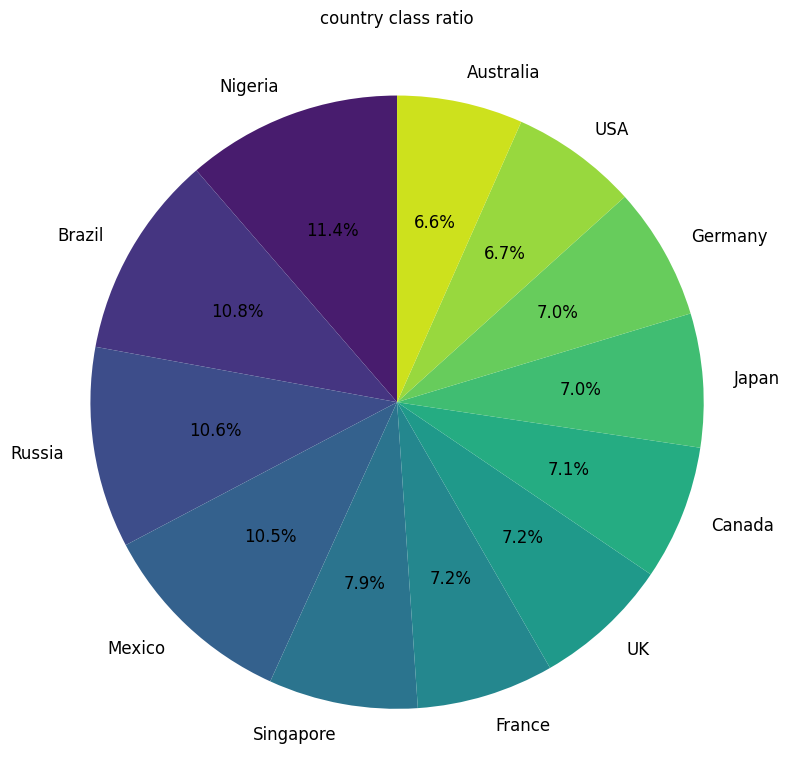

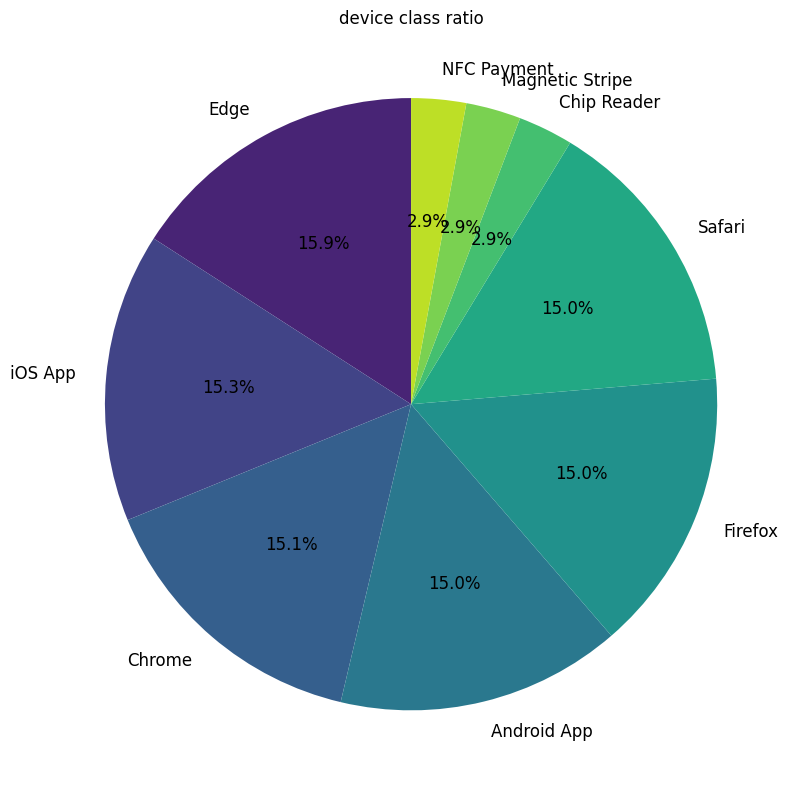

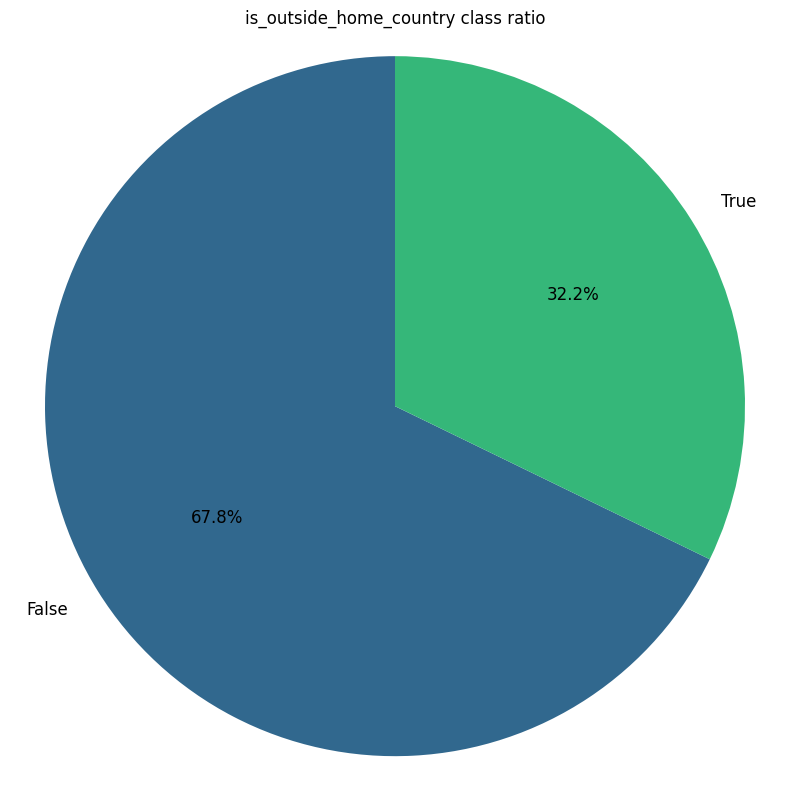

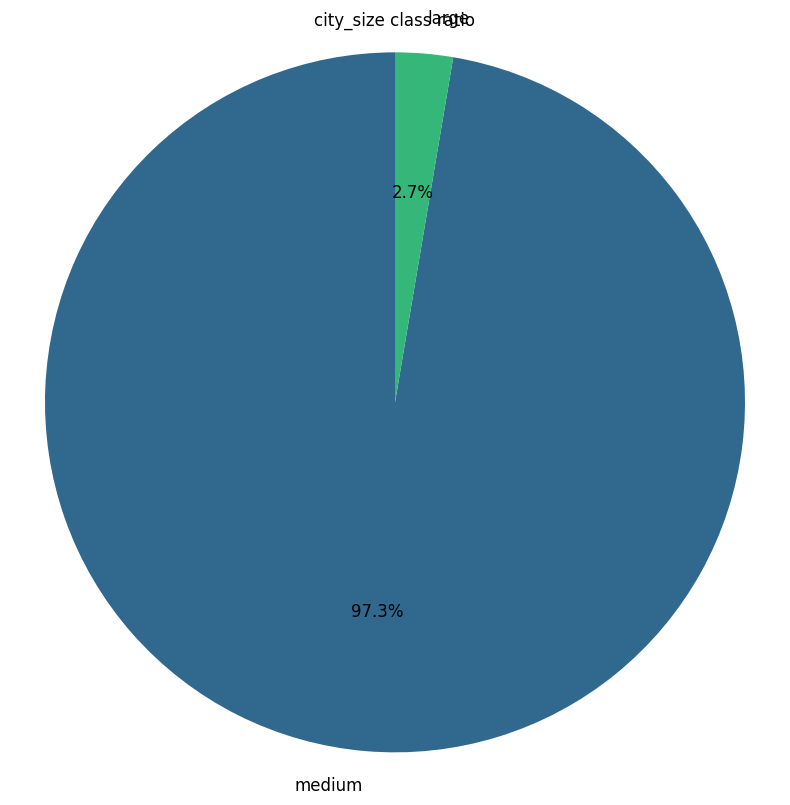

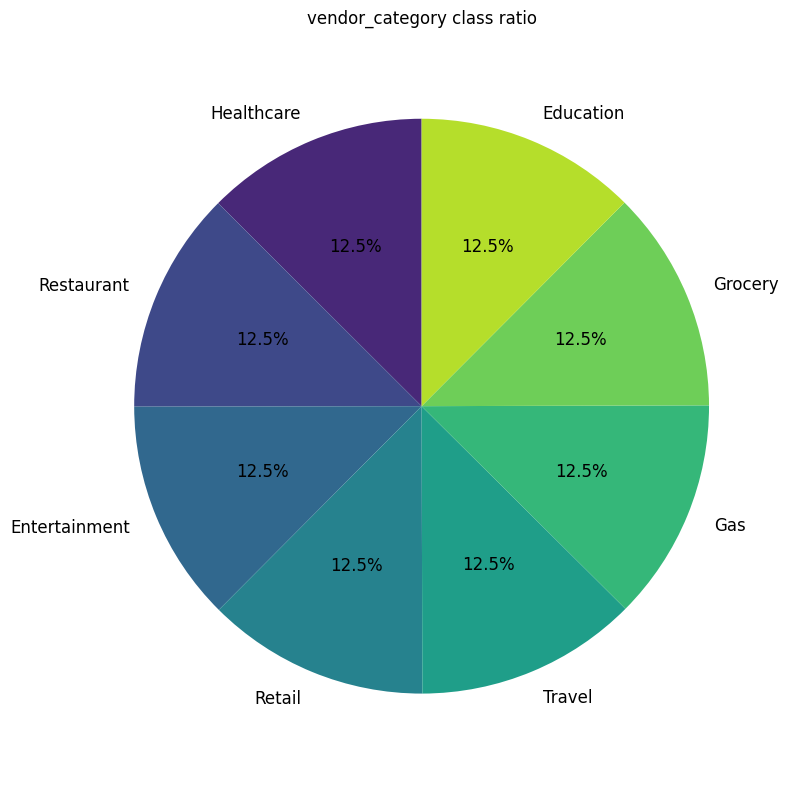

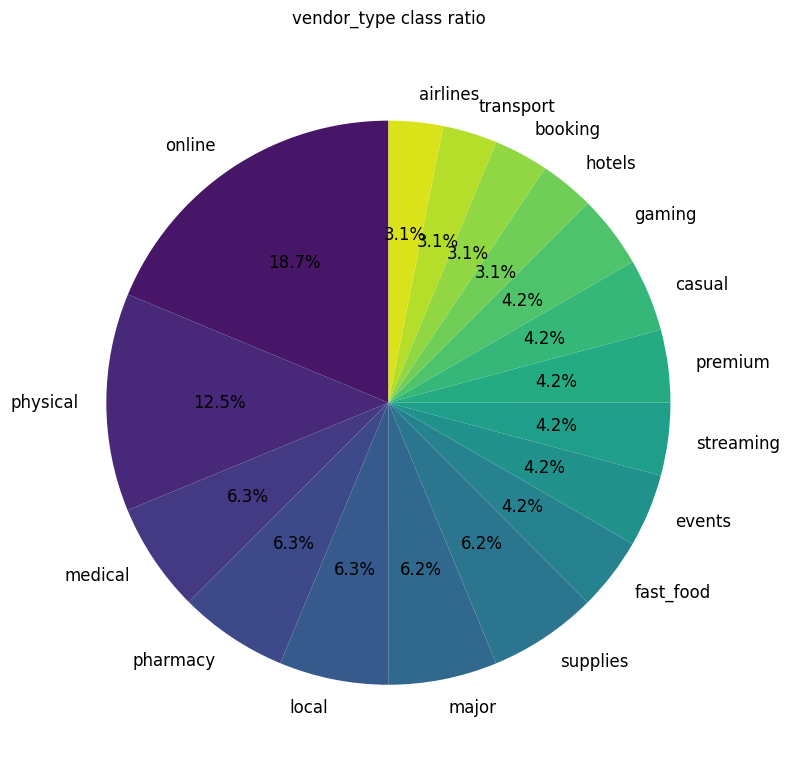

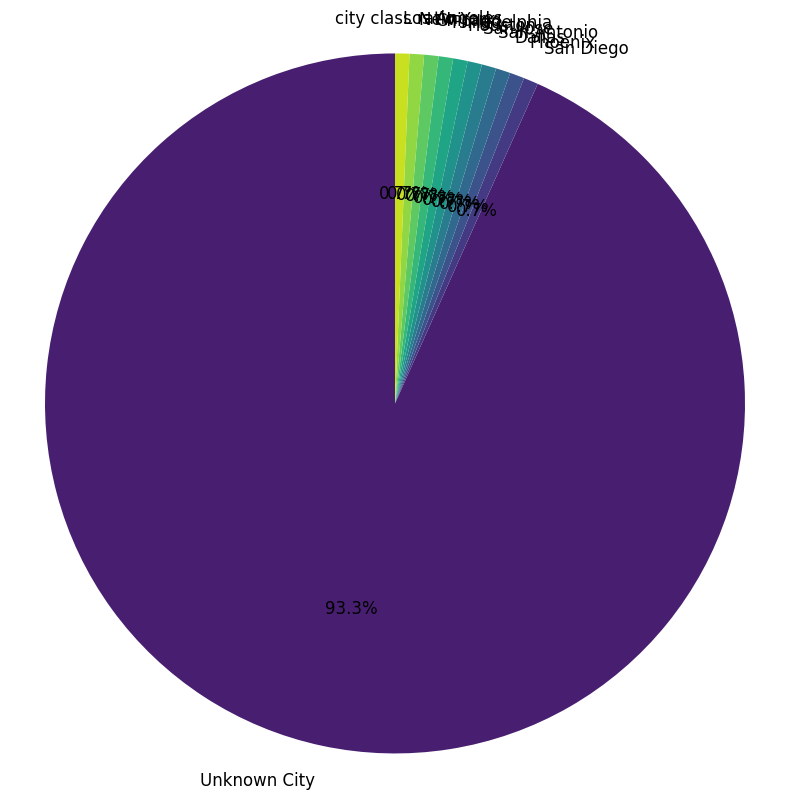

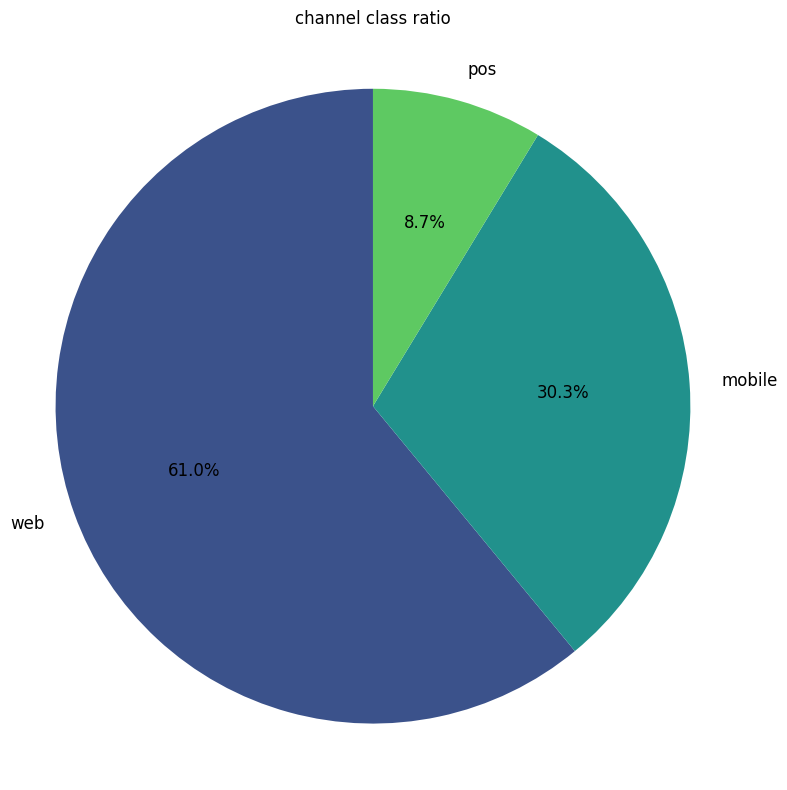

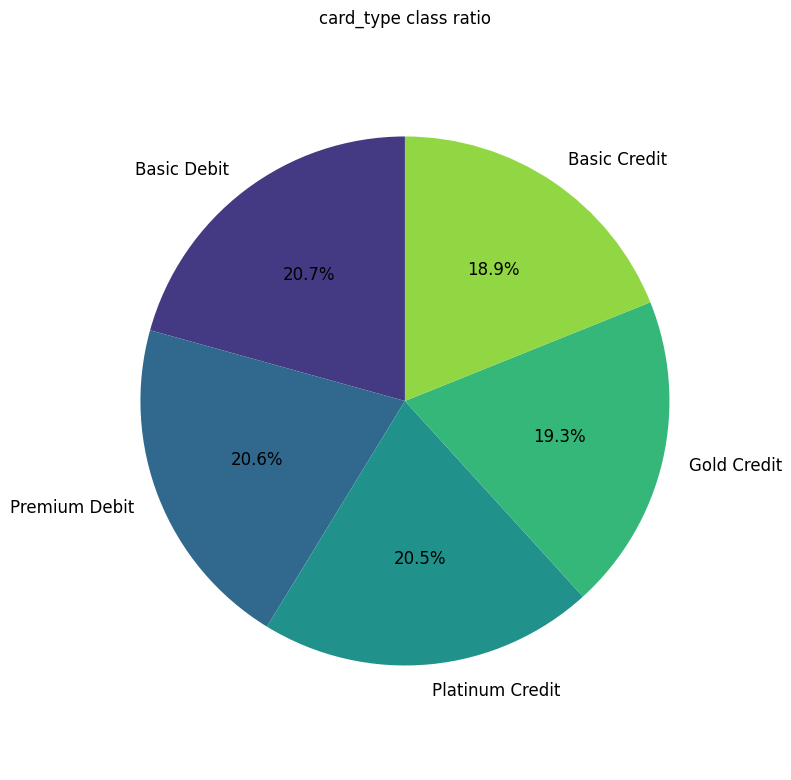

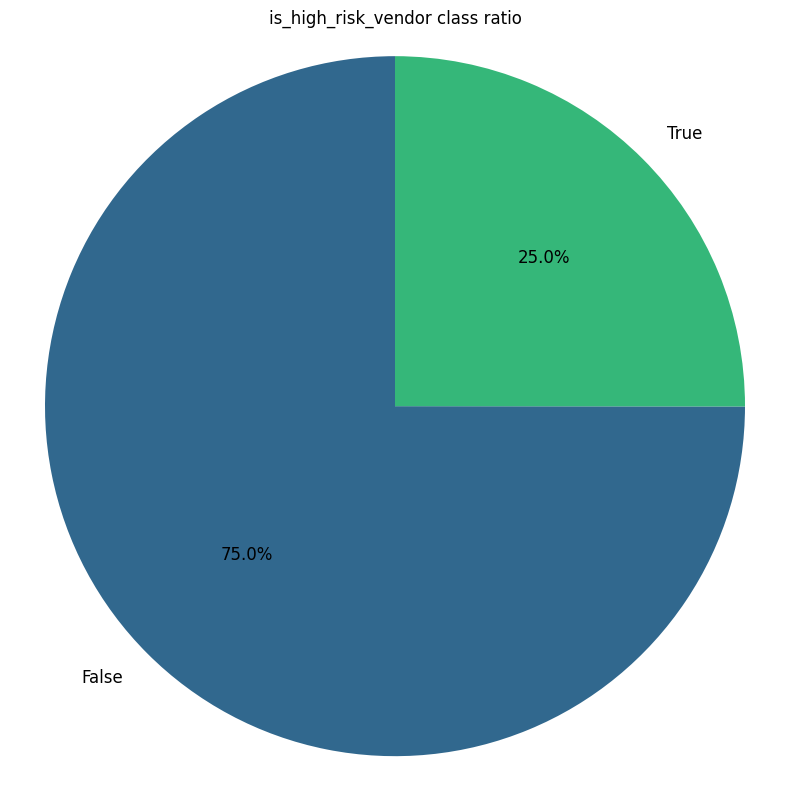

In [11]:
for feature in show_features:
    show_pie(feature)

# Выводы #
В некоторых случаях присутствует явный дисбаланс классов, что 
Что очень важно: целевой класс так же в дисбалансе - мошеннических транзакций намного меньше, чем обычных

# Посмотрим на поведение целевого класса в разрезе других признаков

In [12]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
show_features.append('hour')
show_features.append('day_of_week')

In [ ]:
# def show_barplot(feature):
#     bar_df = df.groupby(feature)['is_fraud'].mean().round(2)

#     fig = px.bar(data_frame=bar_df, y=bar_df.values, x=bar_df.index, color=bar_df.index,
#                  color_discrete_sequence=px.colors.sequential.Viridis,
#                  title=f'Зависимость доли мошеннических операций от признака {feature}', text_auto=True)
#     fig.show()


In [13]:
def show_barplot(feature):
    bar_df = df.groupby(feature)["is_fraud"].mean().round(2).reset_index()

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    colors = sns.color_palette("viridis", len(bar_df))

    ax = sns.barplot(
        x=feature, y="is_fraud", data=bar_df, palette=colors, hue=feature, legend=False
    )

    plt.title(
        f"Зависимость доли мошеннических операций от признака {feature}", fontsize=14
    )
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Доля мошеннических операций", fontsize=12)

    # Добавление значений над столбцами
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    plt.xticks(rotation=45 if len(bar_df) > 5 else 0)
    plt.tight_layout()
    plt.show()

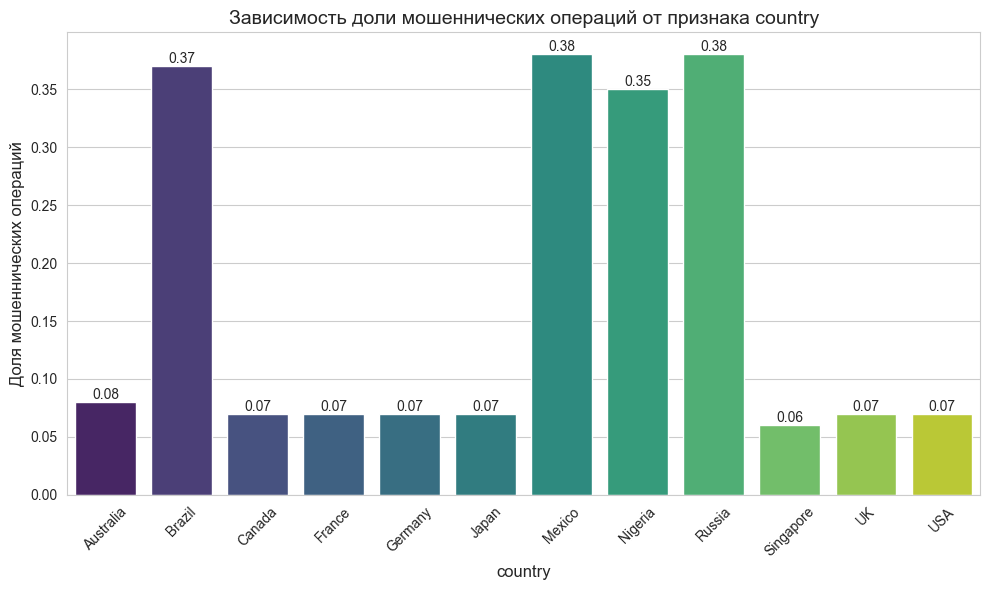

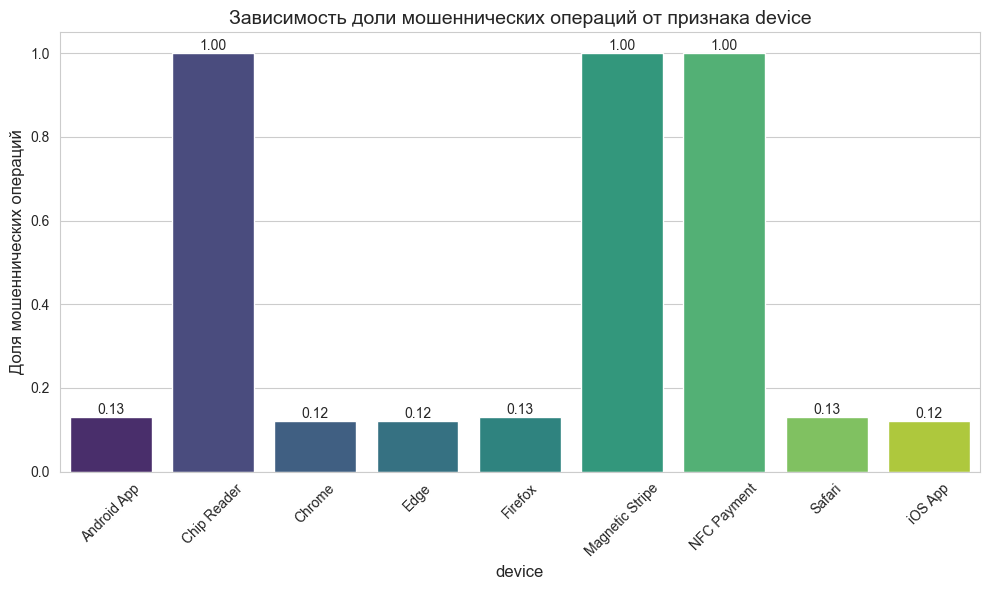

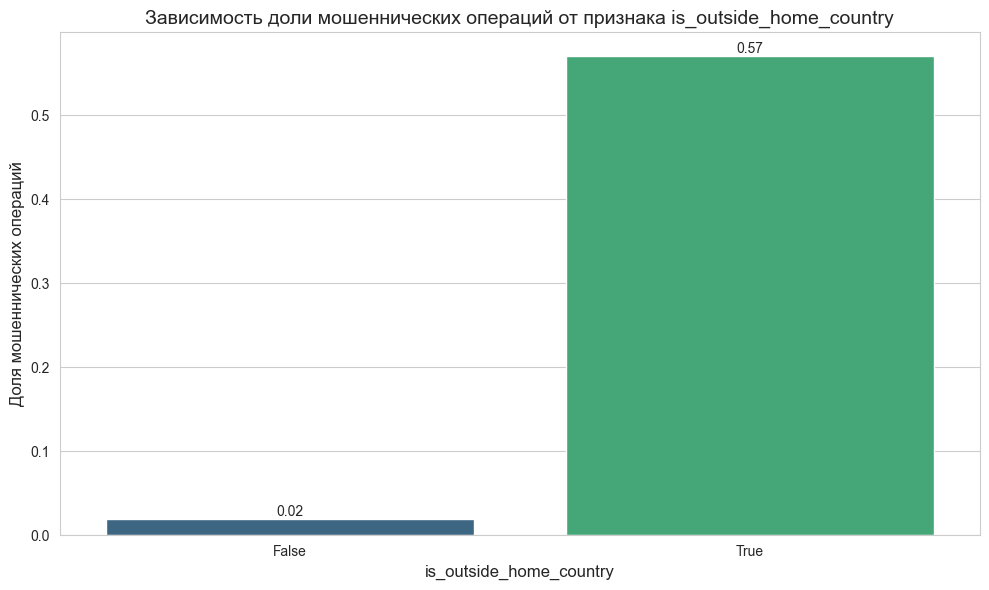

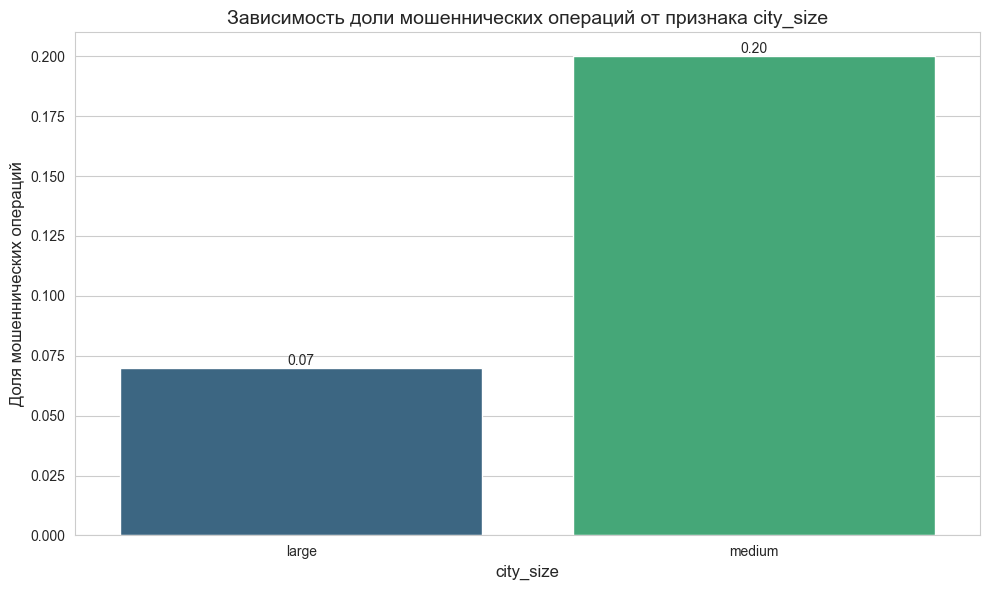

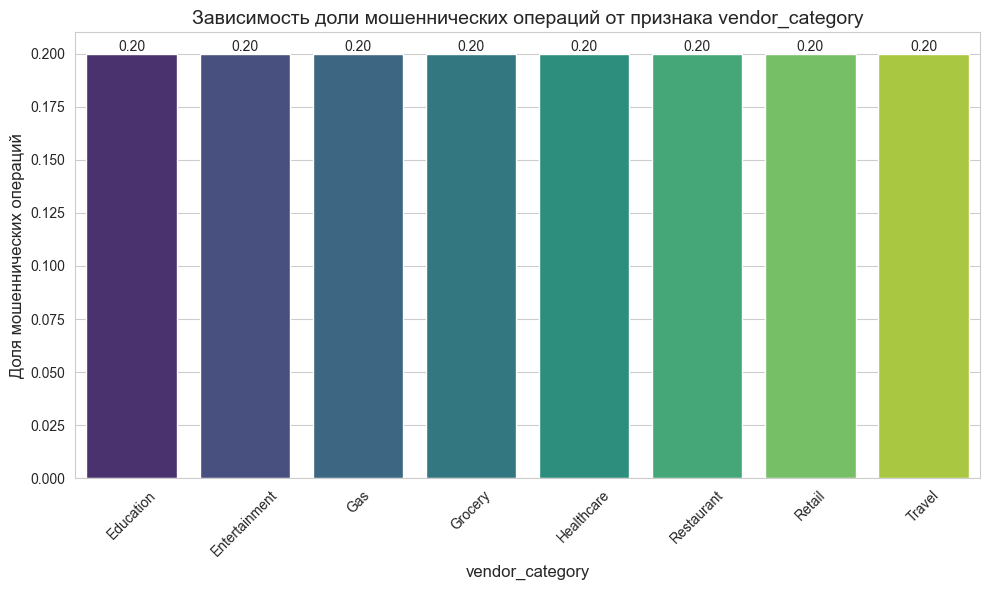

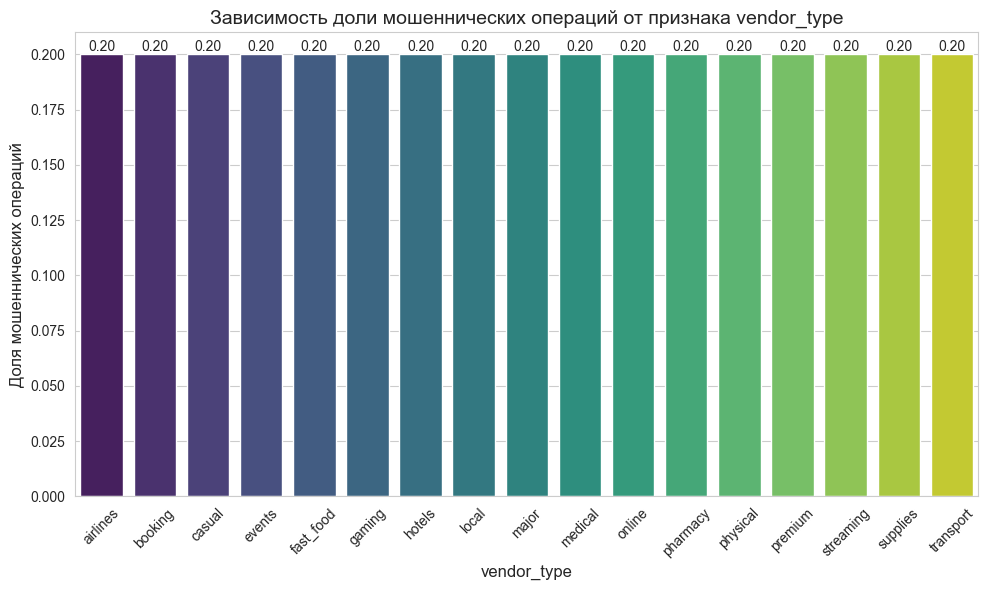

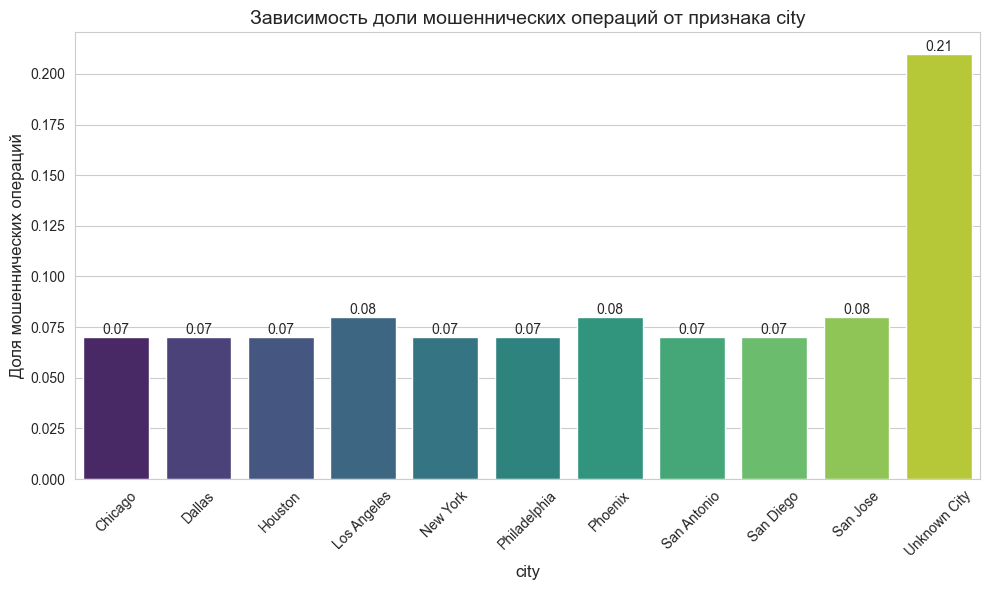

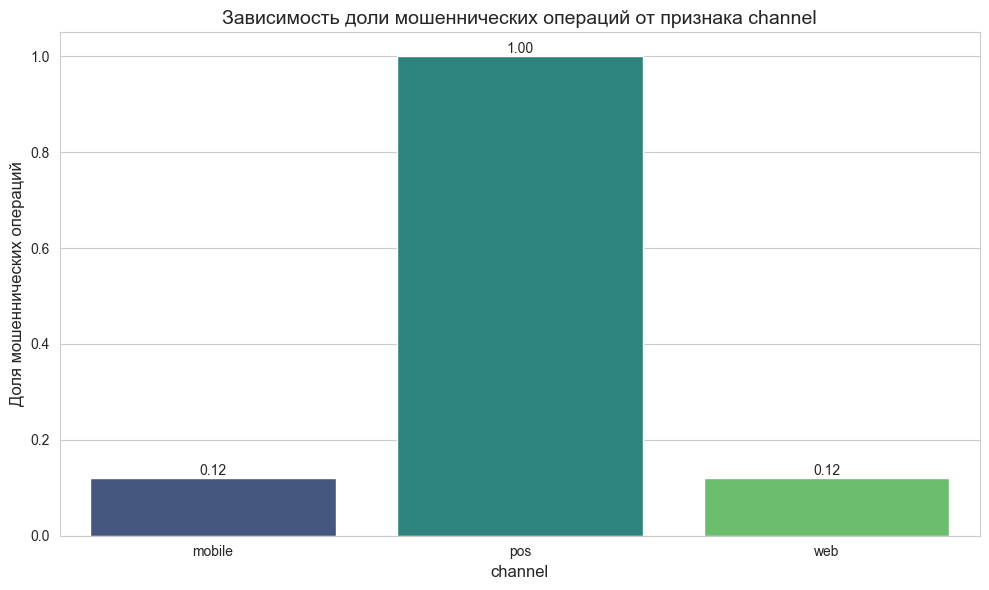

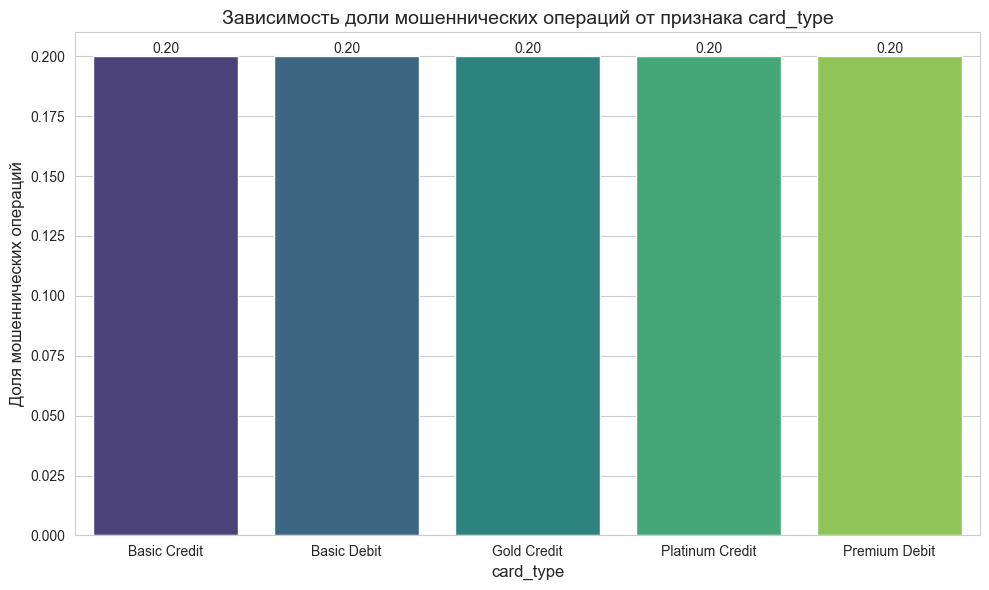

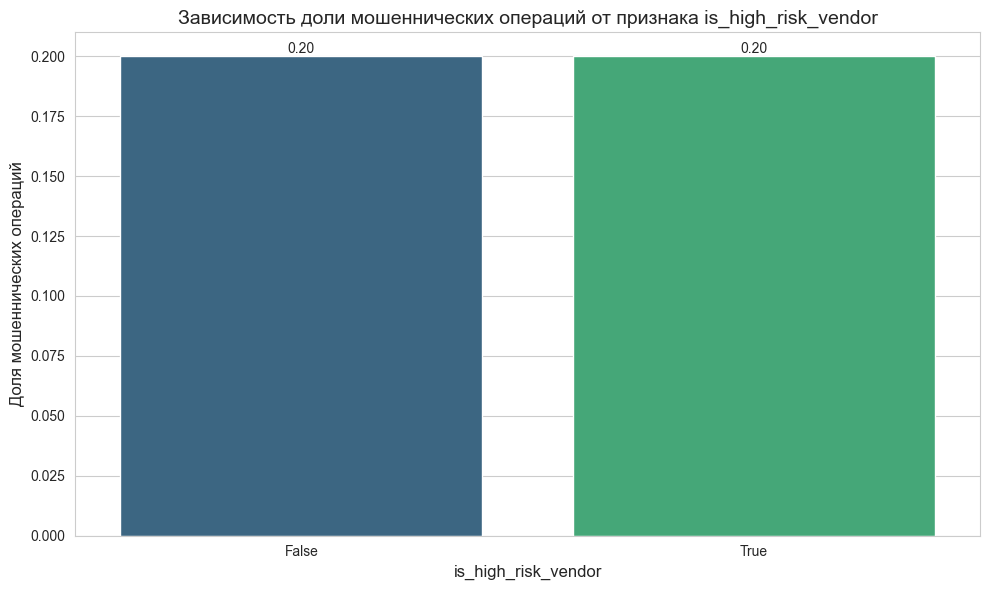

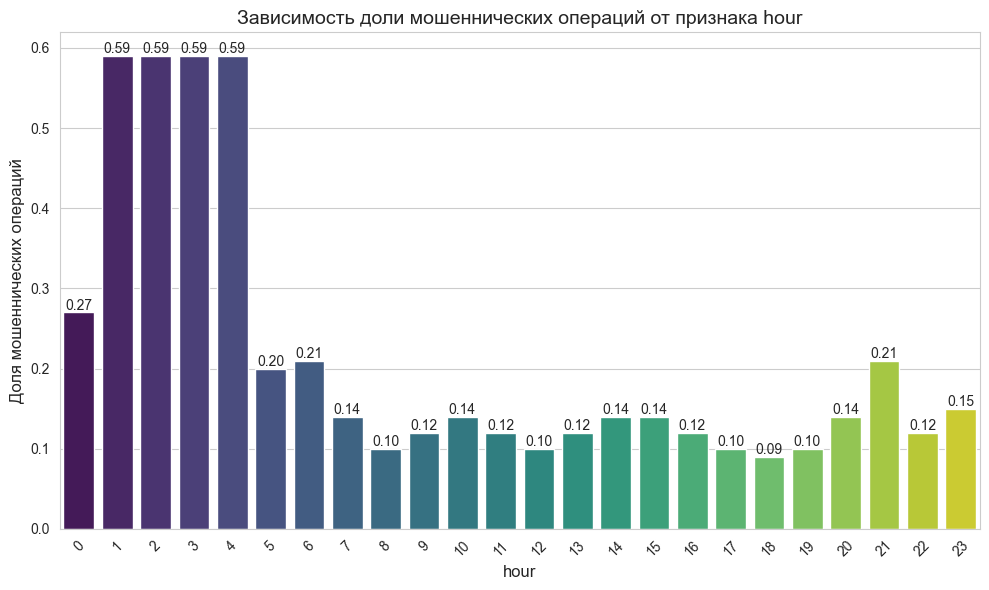

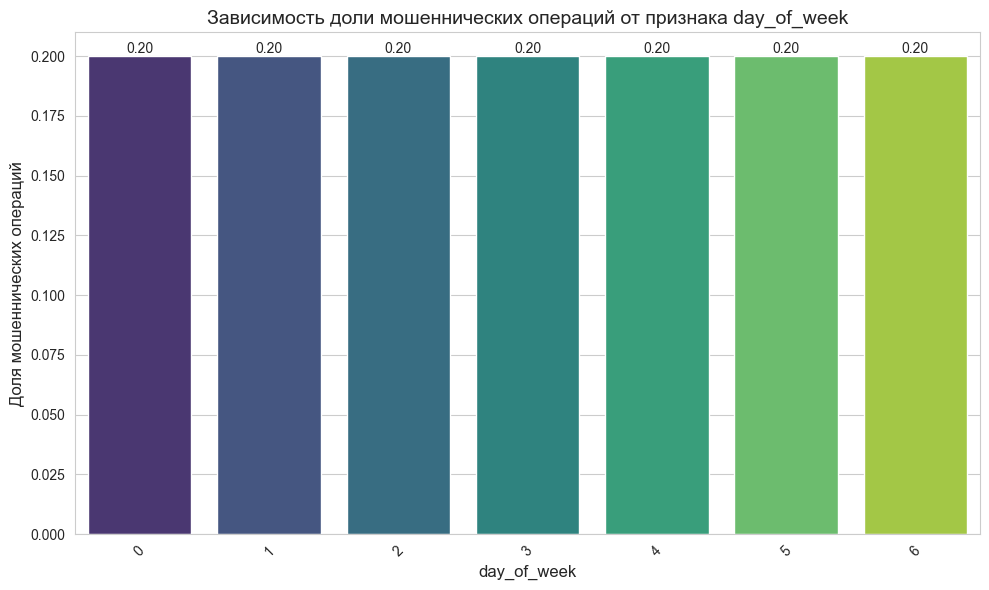

In [14]:
for feature in show_features:
    show_barplot(feature)
    

# Выводы #
1) Мошеннические операции намного чаще производят поздней ночью
2) Активность мошенничества не зависит от дня недели, является ли категория вендора рискованной, типа карты, города (если он известен), вендора
3) Видим, что Мексика, Россия, Бразилия и Нигерия сильно выделяются на фоне остальных стран по доли мошеннических операций
4) С браузеров и телефонов намного меньше доли мошеннических операций
5) Если операция производится вне страны клиента, то высок шанс, что это мошенничество
6) В городах поменьше больше шанс, что операция мошенническая

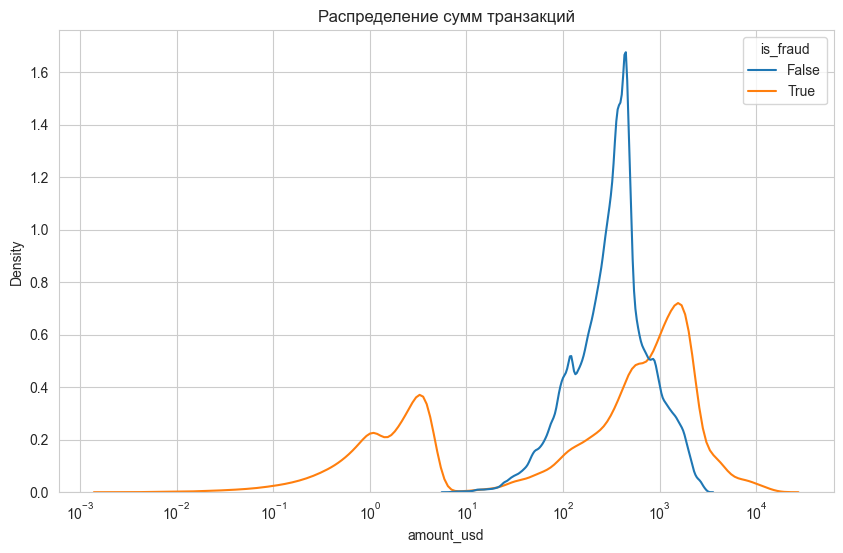

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='amount_usd', hue='is_fraud', common_norm=False, log_scale=True)
plt.title('Распределение сумм транзакций')
plt.show()


Логарифм суммы транзакции при мошеннических операциях имеет бимодальное распределение: пики на малых и крупных суммах

In [ ]:
# def show_barplot_amount(feature):
#     bar_df = df.groupby([feature ,'is_fraud'], as_index=False)['amount_usd'].median().round(0)

#     fig = px.bar(data_frame=bar_df, y='amount_usd', x=feature, color='is_fraud',
#                      color_discrete_sequence=px.colors.sequential.Viridis,
#                      title=f'Зависимость размера оплаты от признаков is_fraud и {feature}', text_auto=True)
#     fig.update_layout(barmode='group')
#     fig.show()


In [22]:
def show_barplot_amount(feature):
    bar_df = (
        df.groupby([feature, "is_fraud"], as_index=False)["amount_usd"]
        .median()
        .round(0)
    )

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    colors = sns.color_palette("viridis", 2)

    ax = sns.barplot(
        x=feature,
        y="amount_usd",
        hue="is_fraud",
        data=bar_df,
        palette=colors,
        legend=False
    )

    plt.title(
        f"Зависимость размера оплаты от признаков is_fraud и {feature}", fontsize=14
    )
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Медианная сумма оплаты (USD)", fontsize=12)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

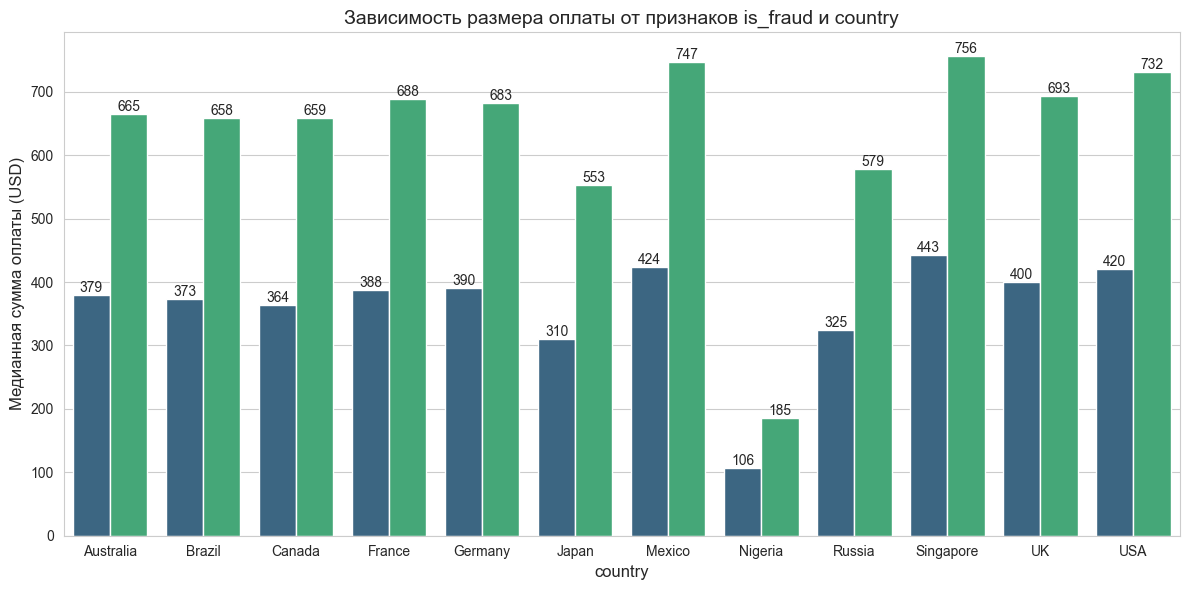

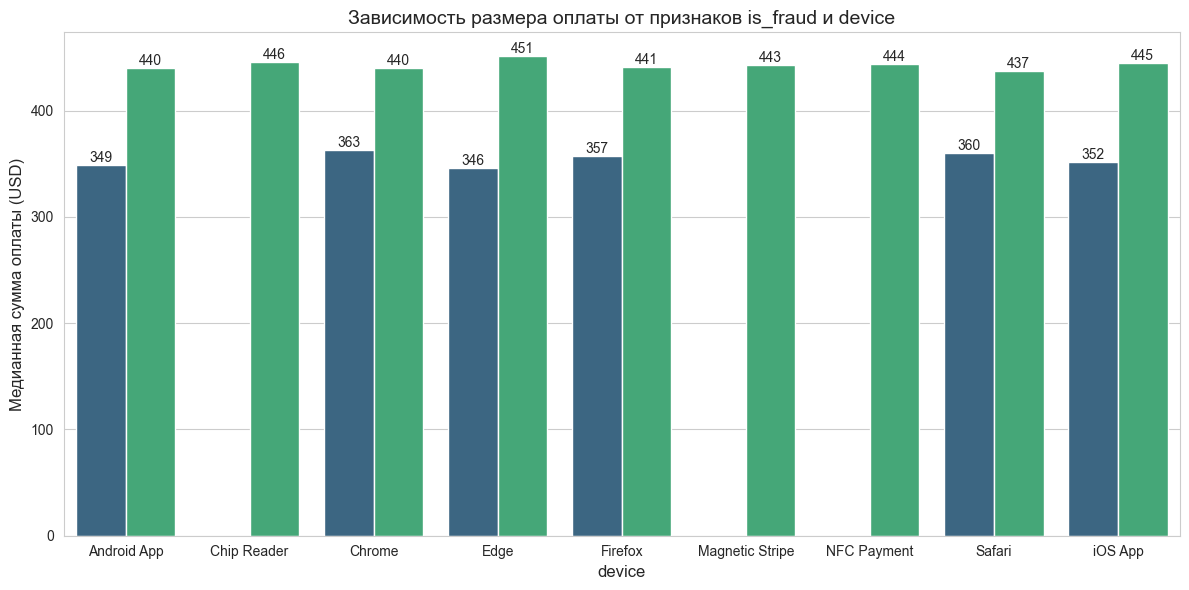

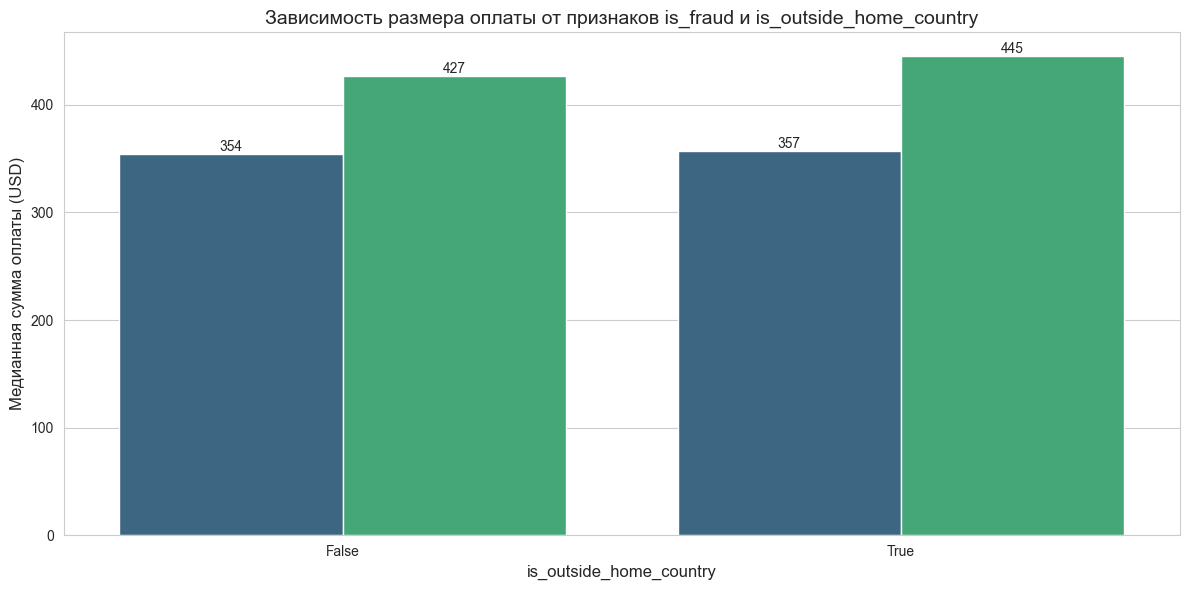

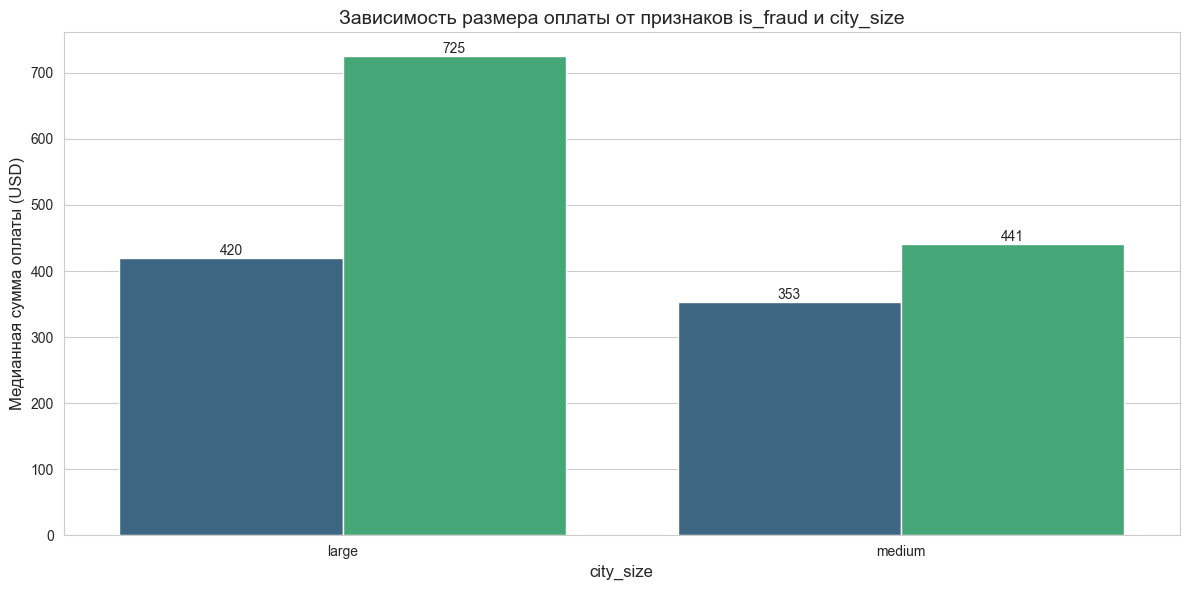

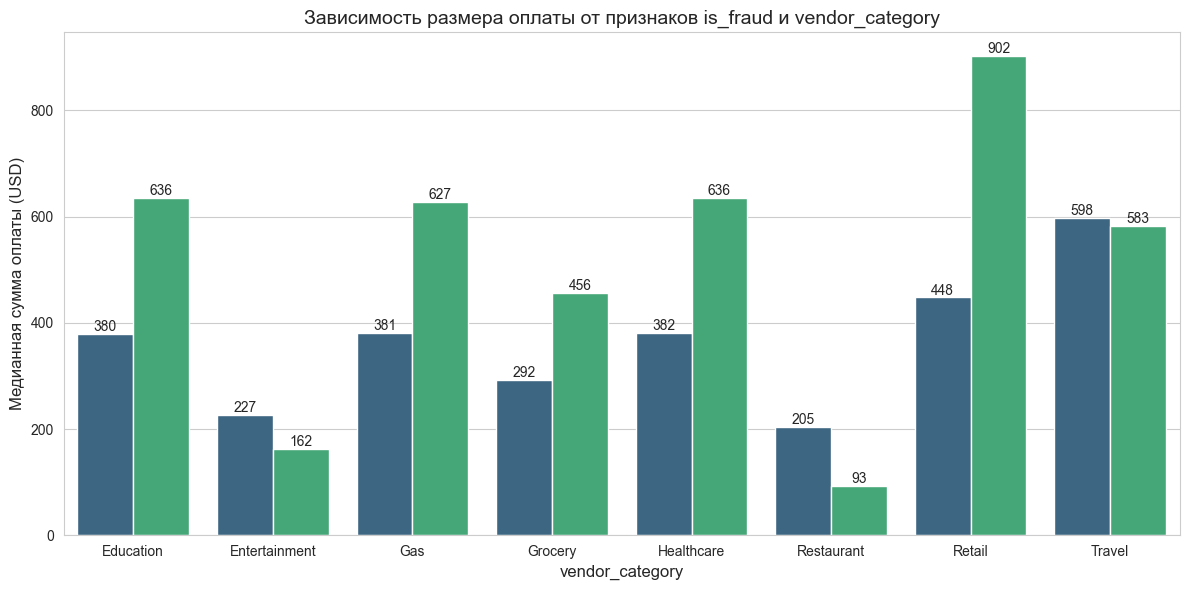

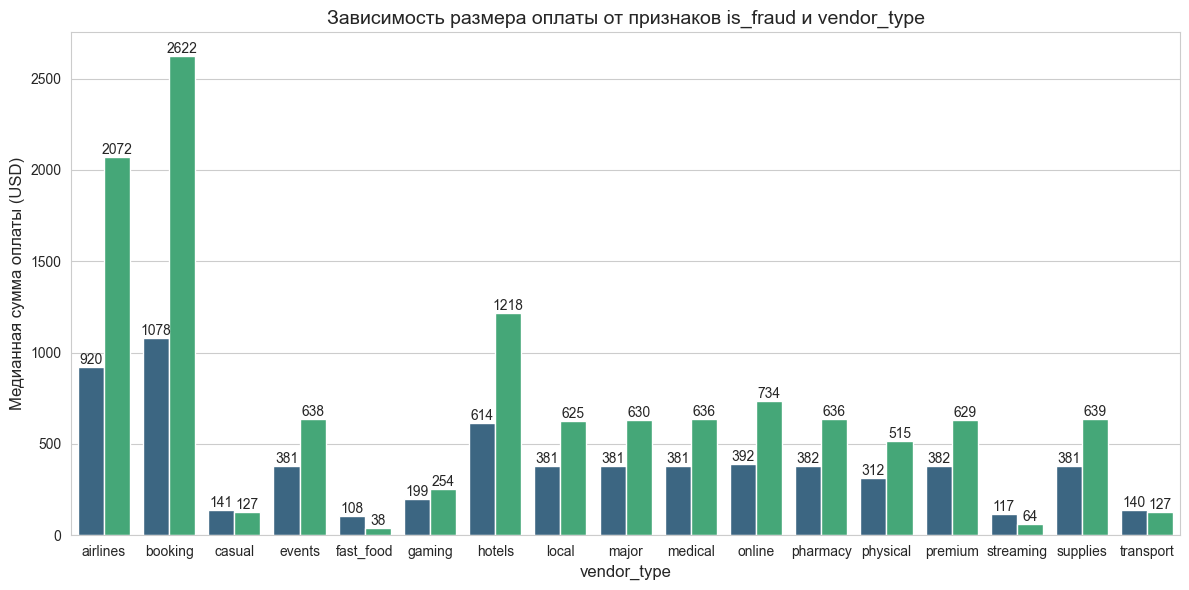

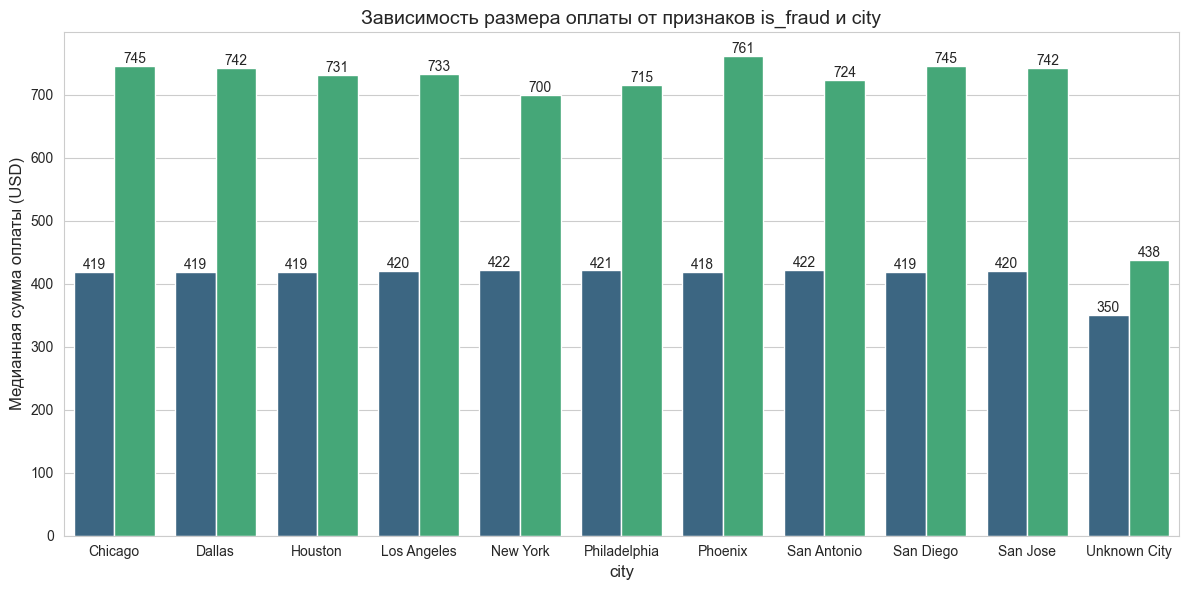

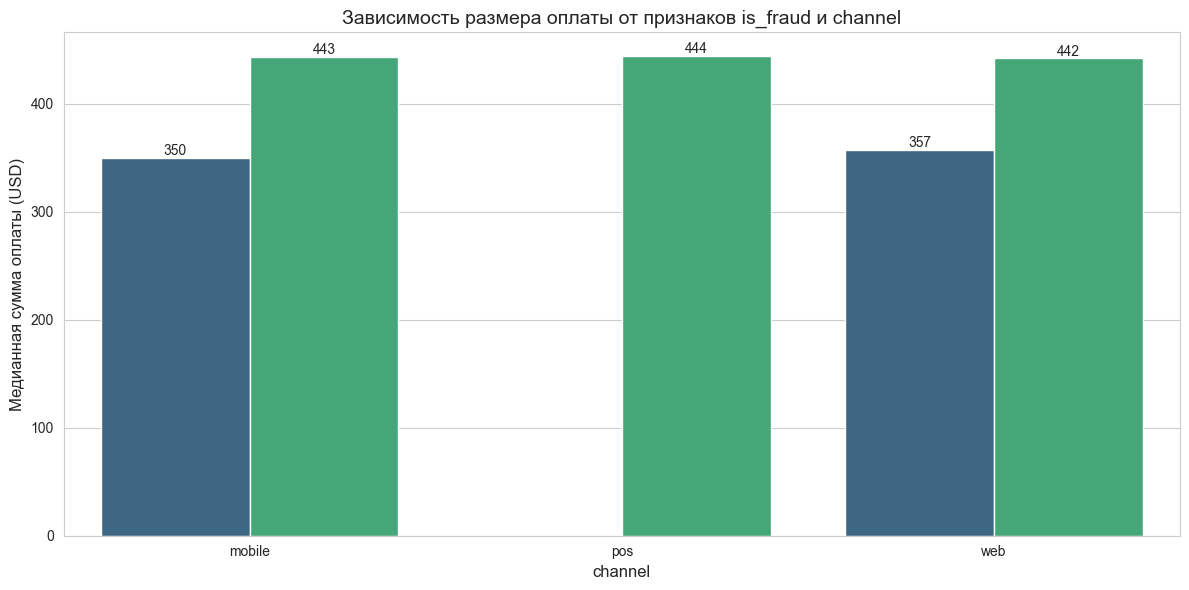

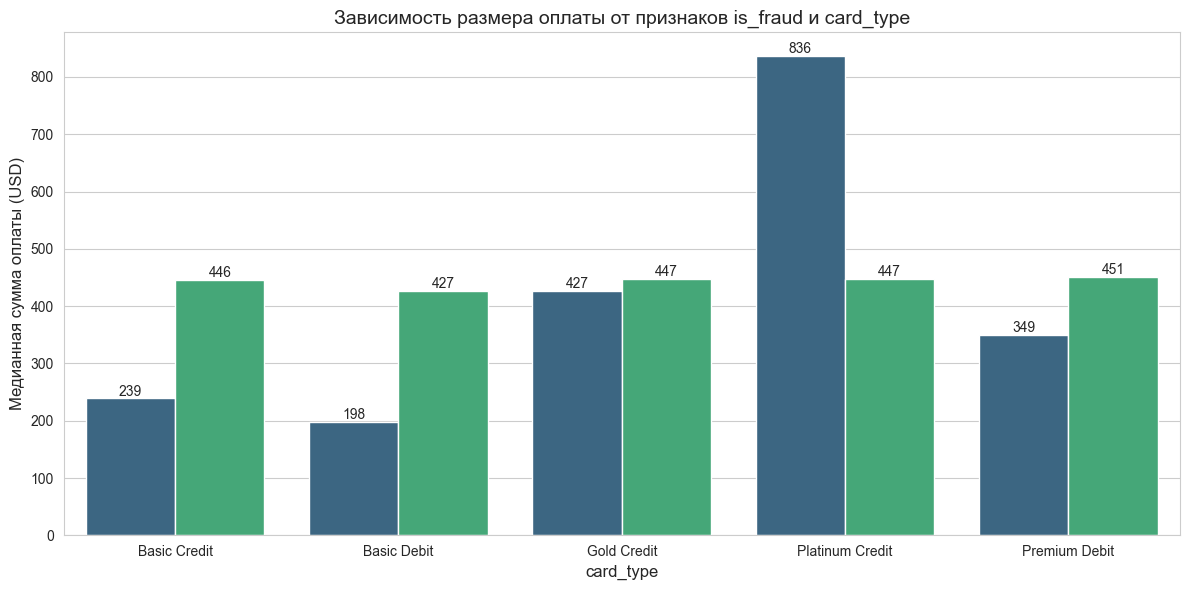

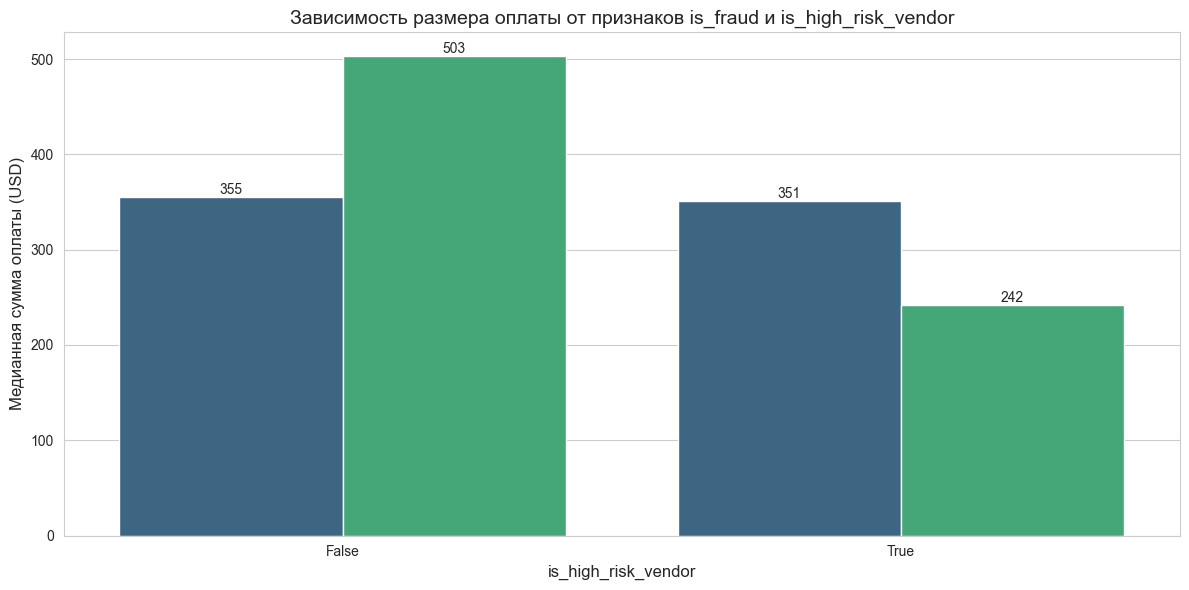

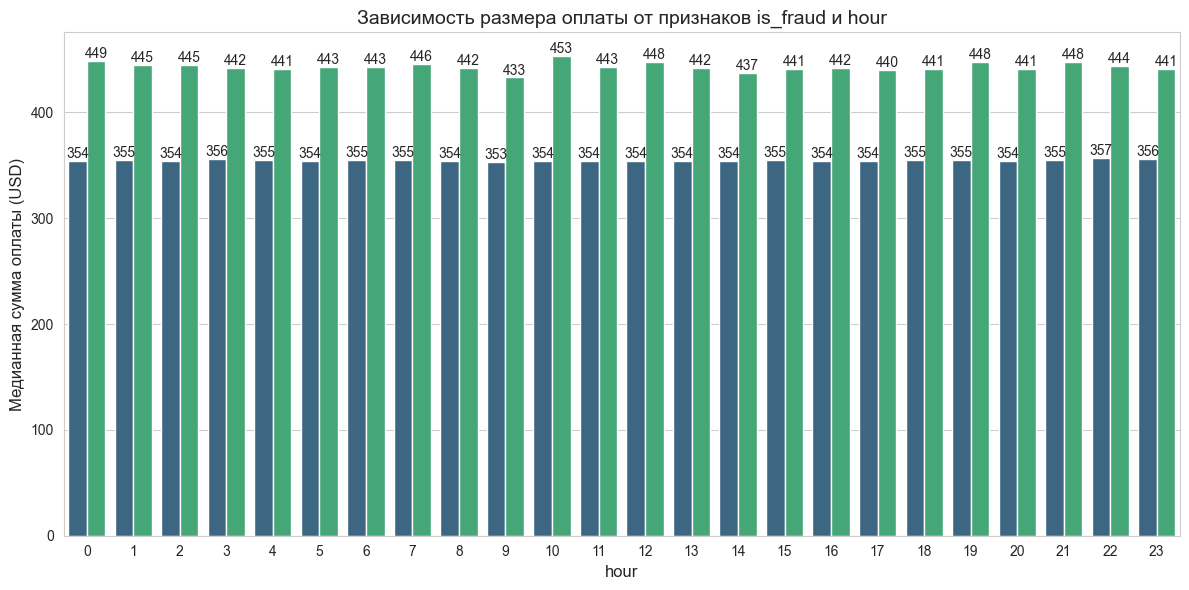

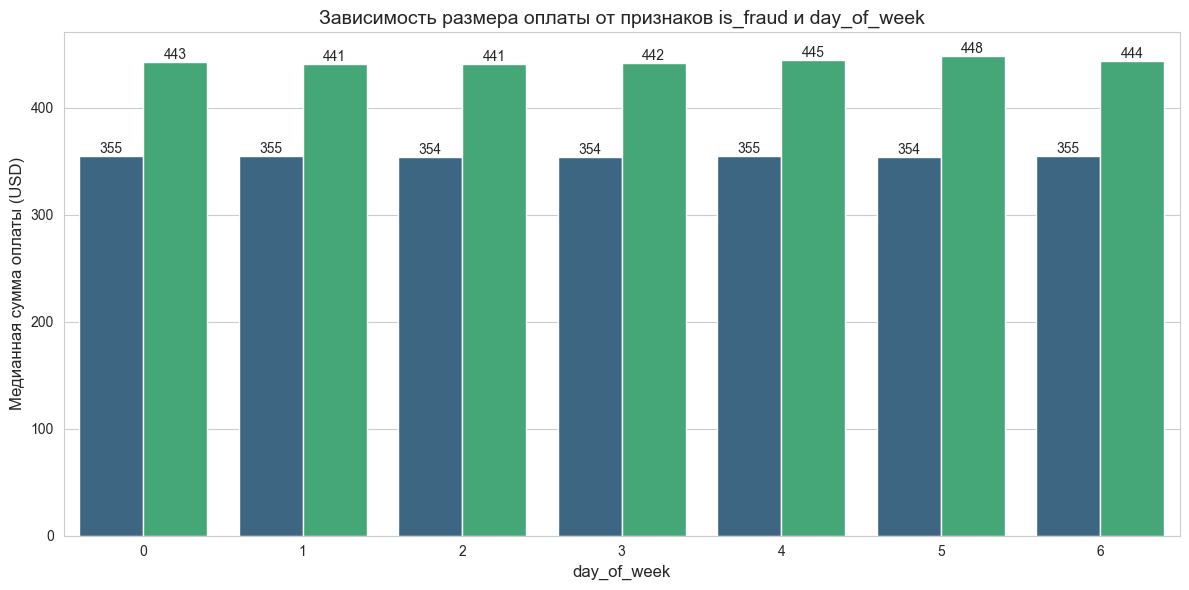

In [23]:
for feature in show_features:
    show_barplot_amount(feature)
    

Видим почти везде, что медиана суммы мошеннической транзакции больше медианы обычной 

In [24]:
last_hour_features = ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']
for field in last_hour_features:
    df[f'last_hour_{field}'] = df['last_hour_activity'].apply(lambda x: x[field])

In [25]:
# for feature in last_hour_features:
#     bar_df = df.groupby('is_fraud')[f'last_hour_{feature}'].mean().round(0)

#     fig = px.bar(data_frame=bar_df, y=f'last_hour_{feature}', color=bar_df.index,
#                          color_discrete_sequence=px.colors.sequential.Viridis,
#                          title=f'Зависимость {feature} за последний час от is_fraud', text_auto=True)

#     fig.show()

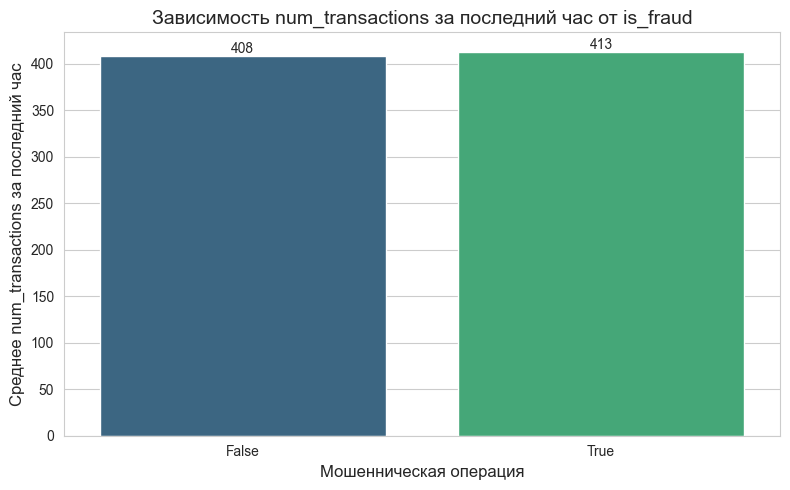

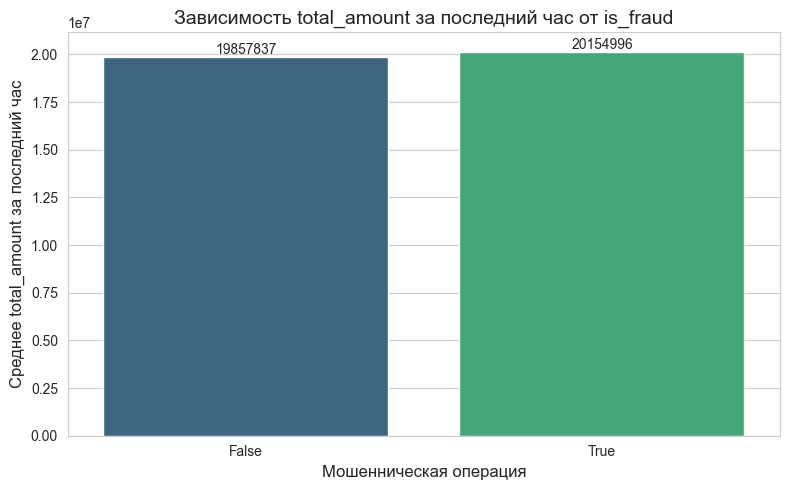

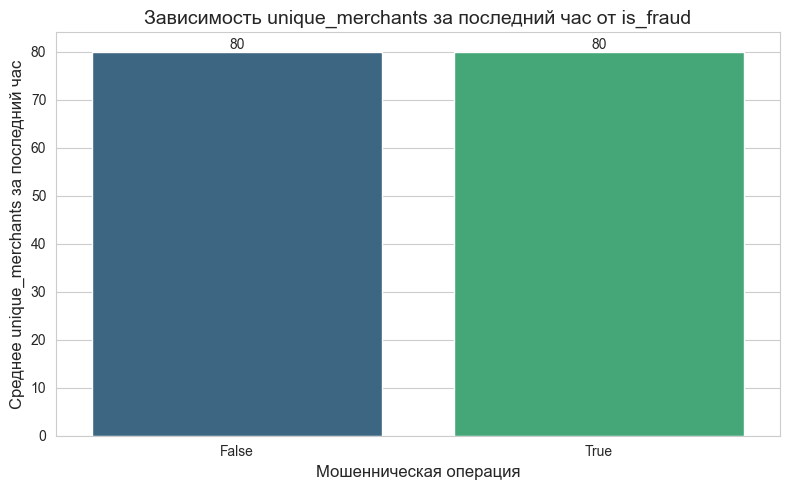

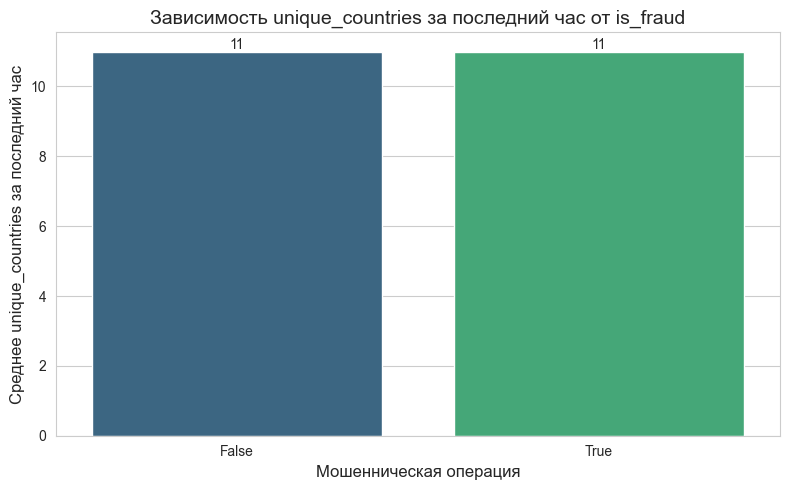

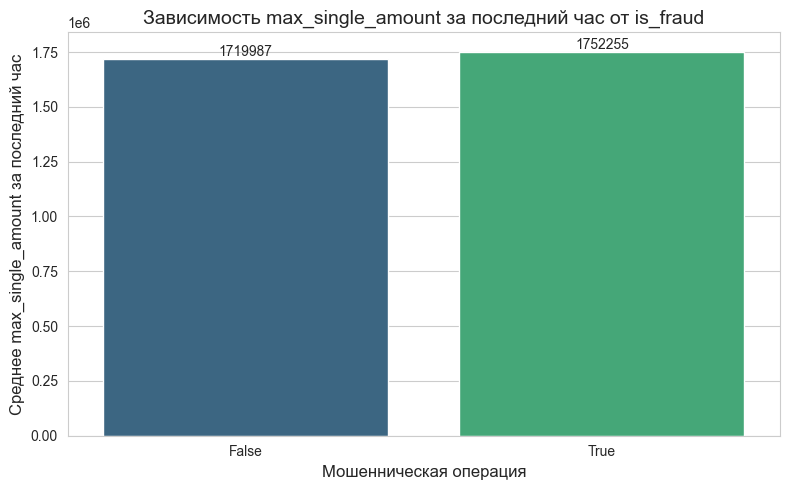

In [26]:
for feature in last_hour_features:
    bar_df = (
        df.groupby("is_fraud")[f"last_hour_{feature}"].mean().round(0).reset_index()
    )

    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")

    colors = sns.color_palette("viridis", len(bar_df))

    ax = sns.barplot(
        x="is_fraud",
        y=f"last_hour_{feature}",
        data=bar_df,
        palette=colors,
        hue="is_fraud",
        legend=False,
    )

    plt.title(f"Зависимость {feature} за последний час от is_fraud", fontsize=14)
    plt.xlabel("Мошенническая операция", fontsize=12)
    plt.ylabel(f"Среднее {feature} за последний час", fontsize=12)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

Мошенническая транзакция никак не влияет на активность за последний час 

<Axes: >

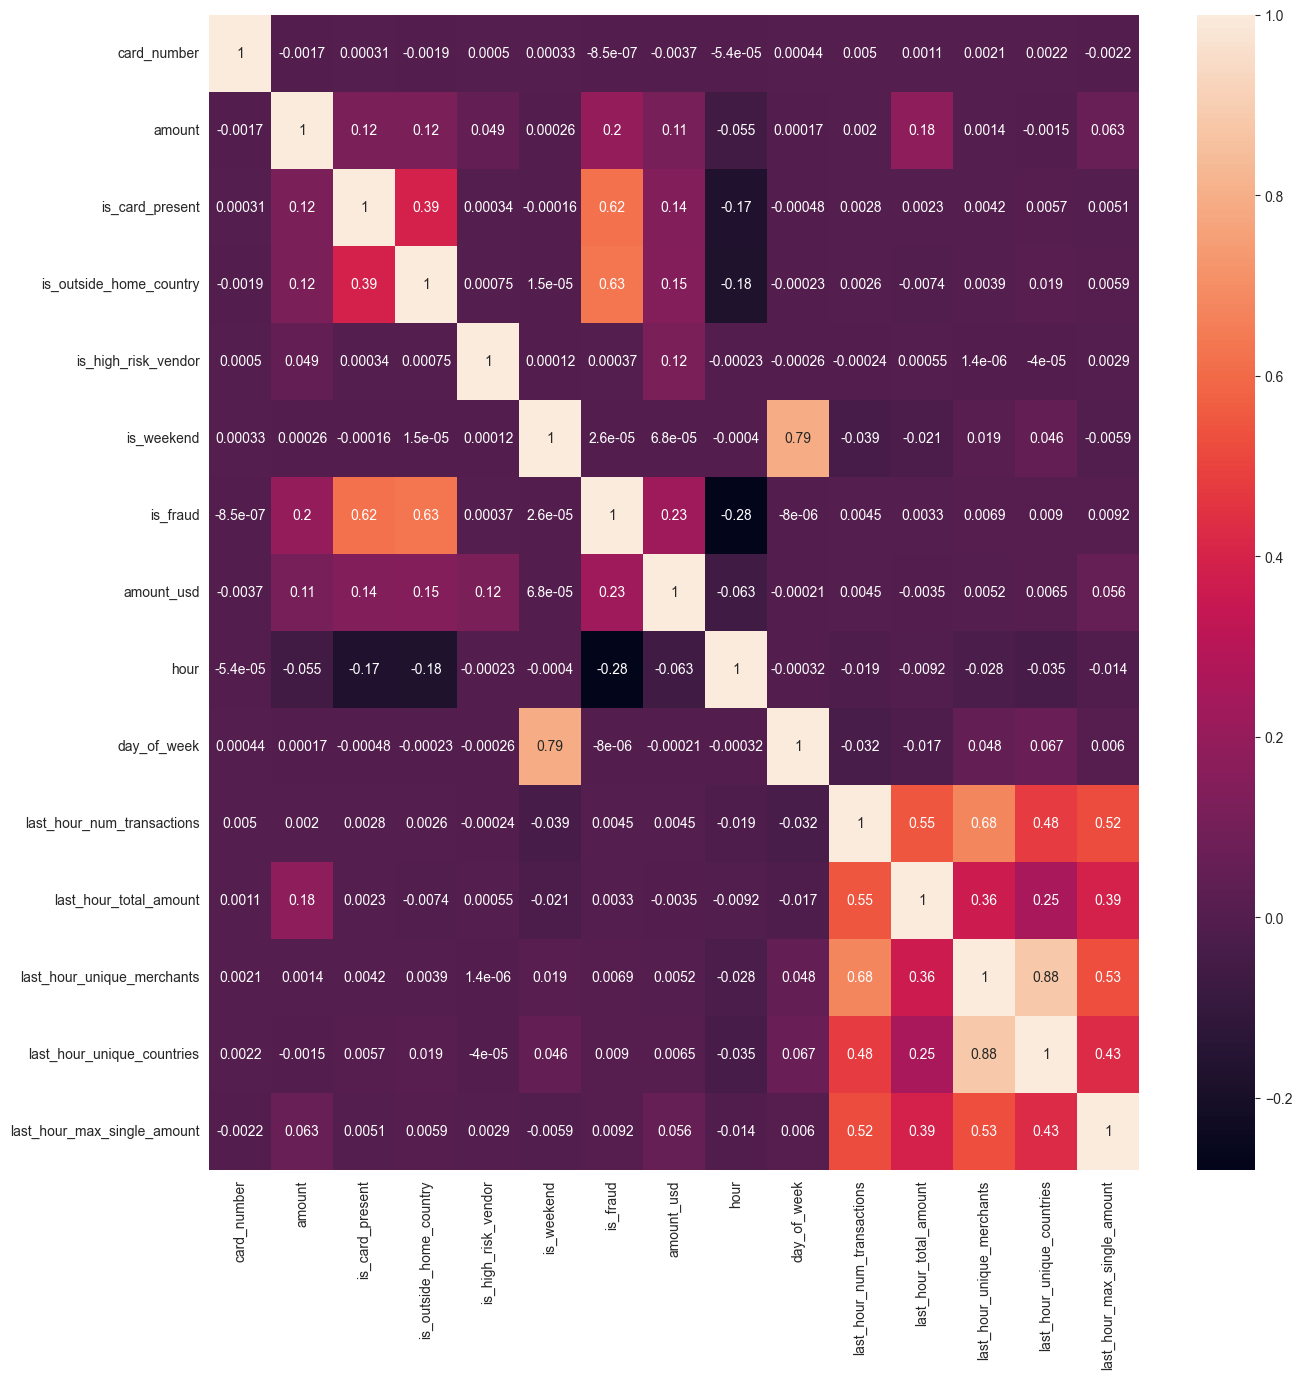

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Как видим из корреляционного анализа, на признак `is_fraud` больше всего влияют `is_card_present` и `is_outside_home_country`

# Посмотрим на траты людей в разрезе других признаков

In [ ]:
# def show_barplot_amount(feature):
#     bar_df = df[df['is_fraud'] == False].groupby(feature)['amount_usd'].median().sort_values().round()

#     fig = px.bar(data_frame=bar_df, y=bar_df.values, x=bar_df.index, color=bar_df.index,
#                  color_discrete_sequence=px.colors.sequential.Viridis,
#                  title=f'Зависимость медианной суммы транзакции от  признака {feature}', text_auto=True)
#     fig.show()


In [18]:
def show_barplot_amount(feature):
    bar_df = (
        df[df["is_fraud"] == False]
        .groupby(feature)["amount_usd"]
        .median()
        .sort_values()
        .round()
        .reset_index()
    )

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    colors = sns.color_palette("viridis", len(bar_df))

    ax = sns.barplot(
        x=feature,
        y="amount_usd",
        data=bar_df,
        palette=colors,
        hue=feature,
        legend=False,
    )

    plt.title(
        f"Зависимость медианной суммы транзакции от признака {feature}", fontsize=14
    )
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Медианная сумма транзакции (USD)", fontsize=12)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

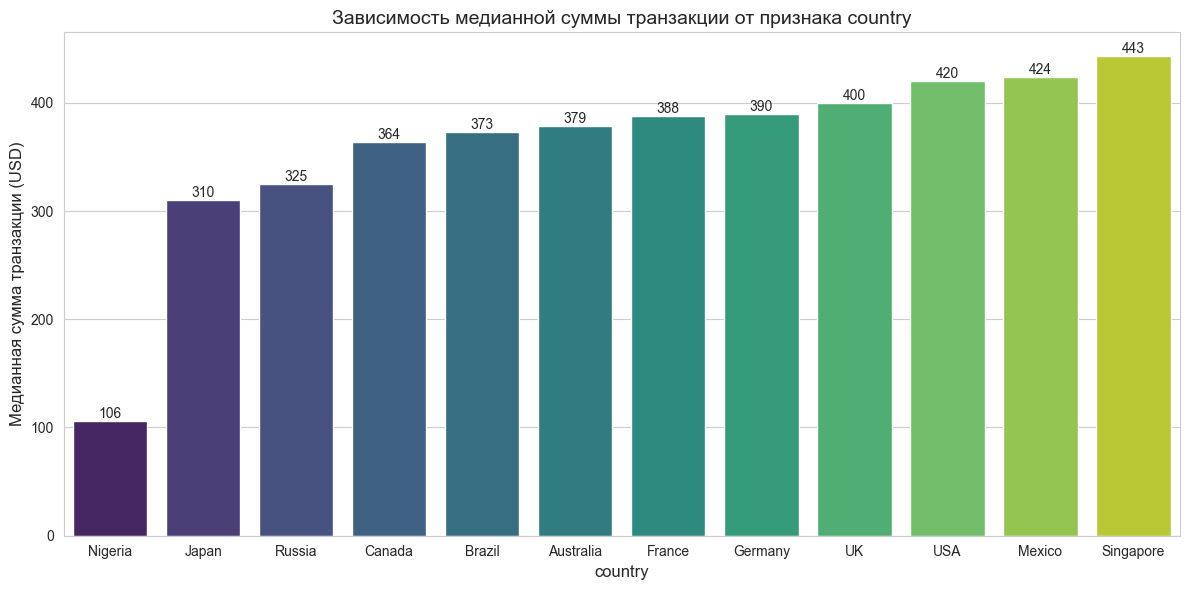

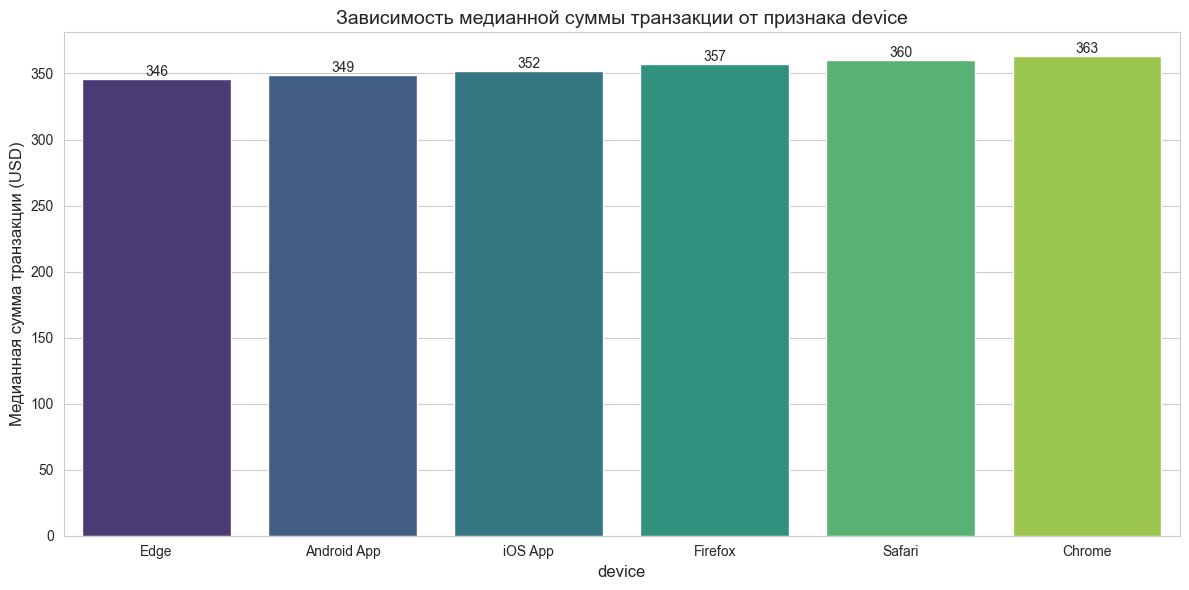

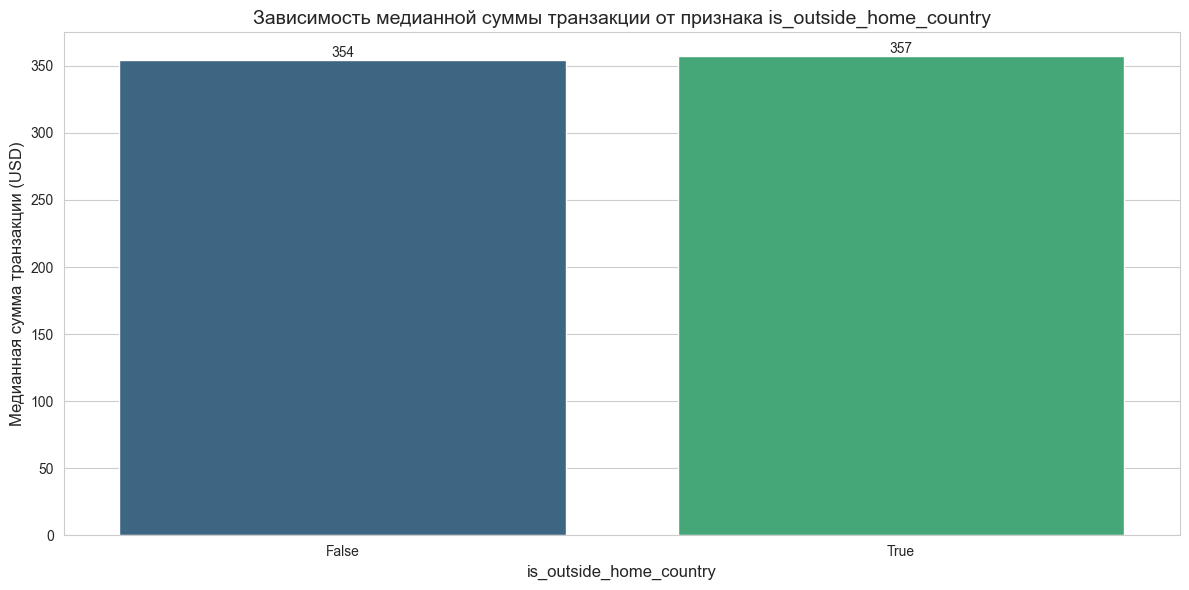

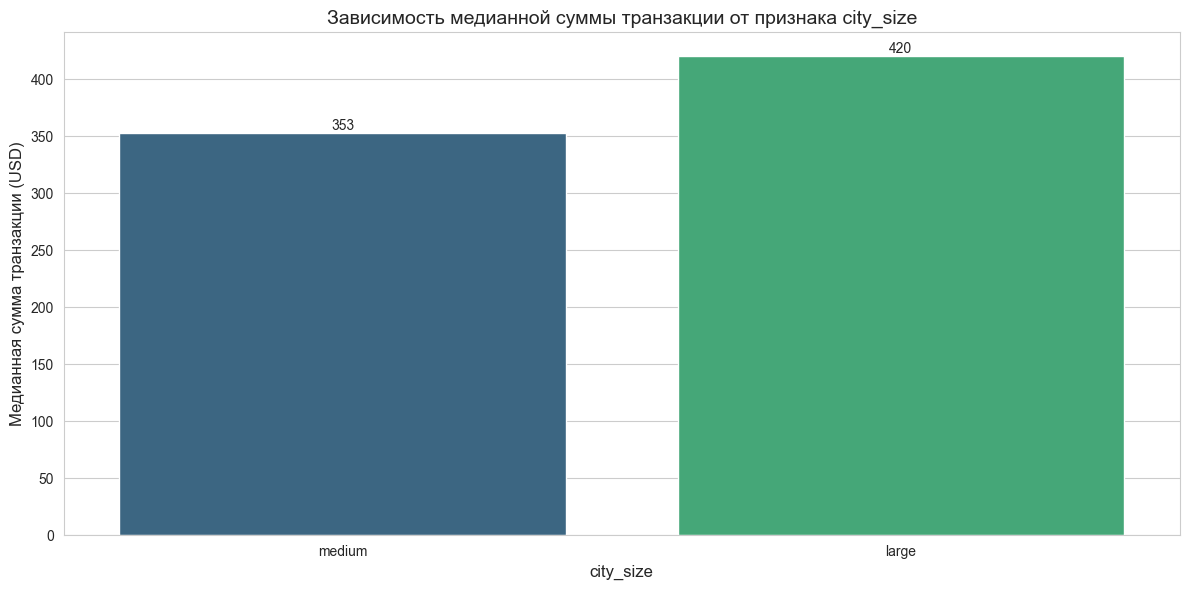

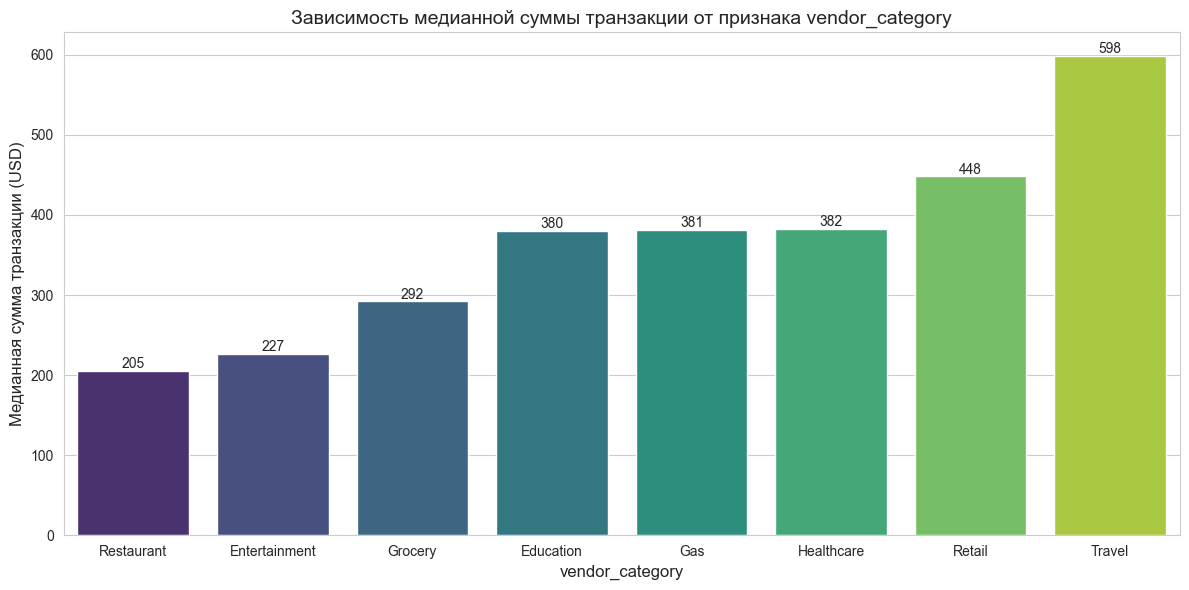

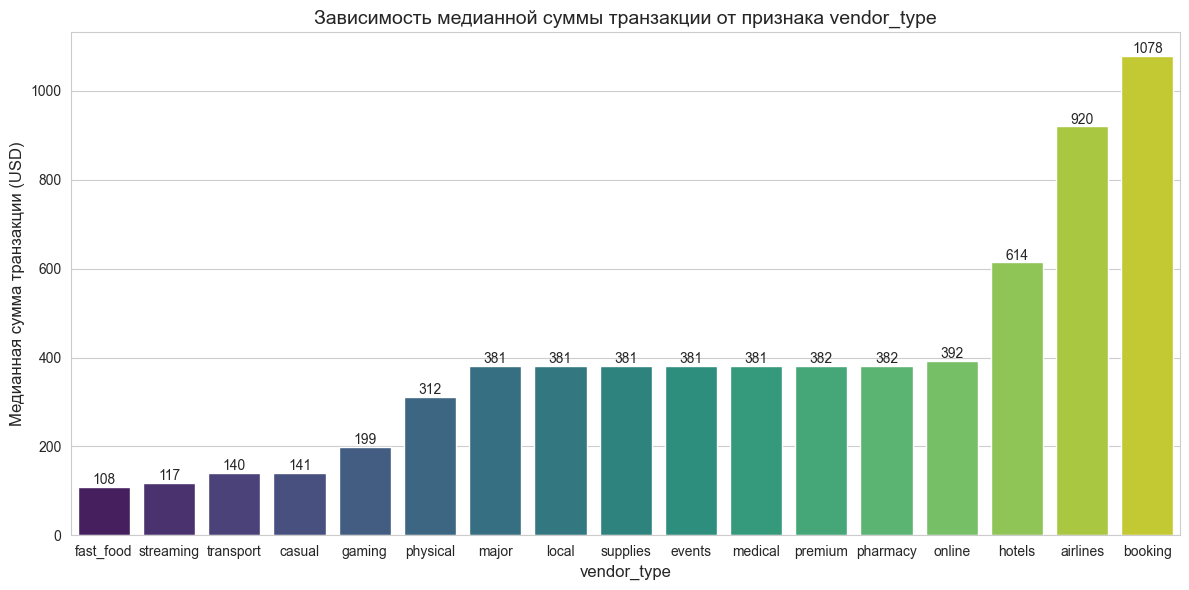

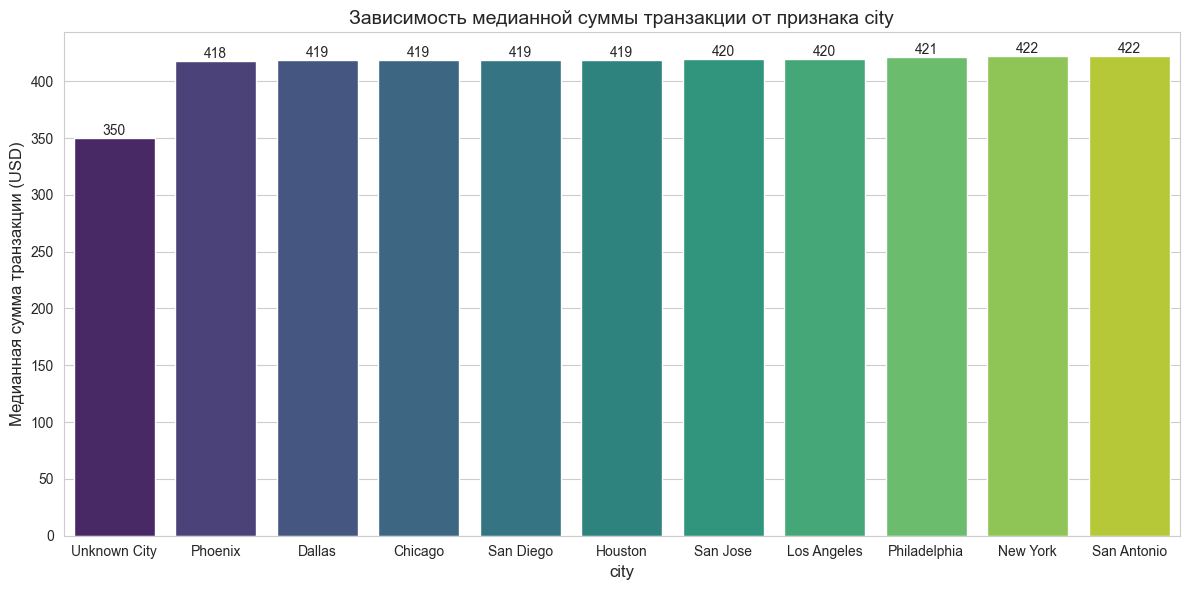

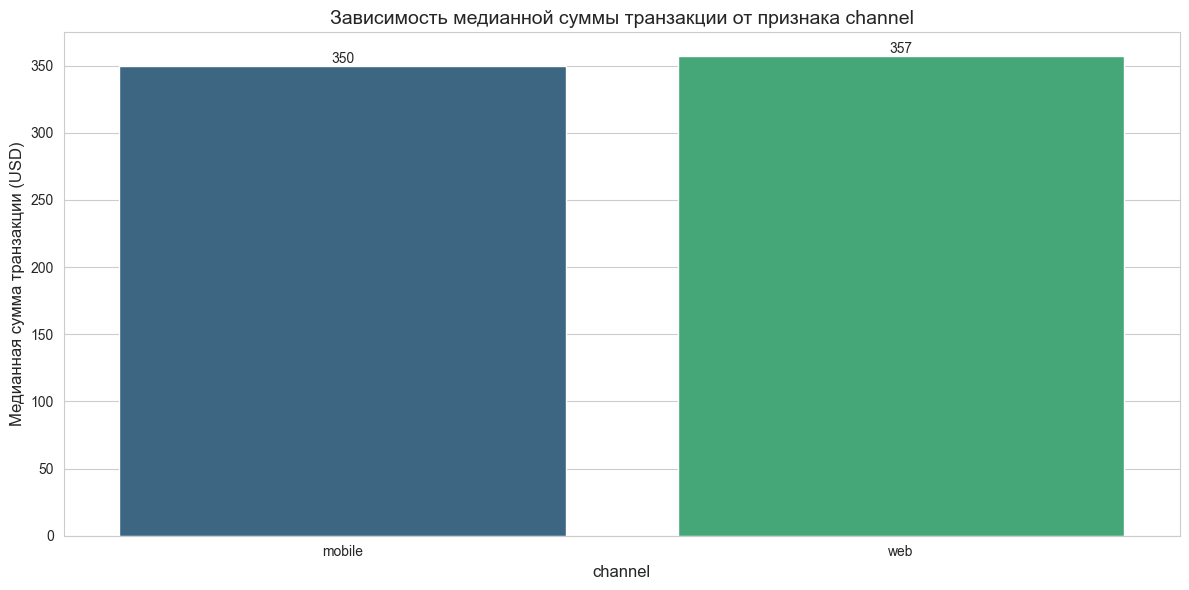

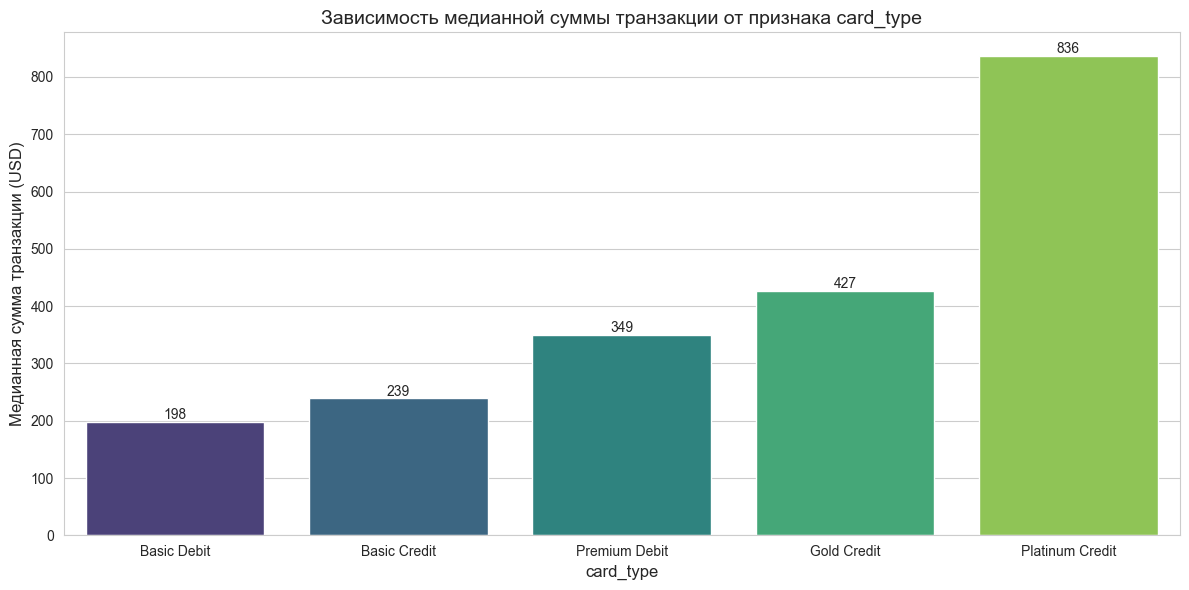

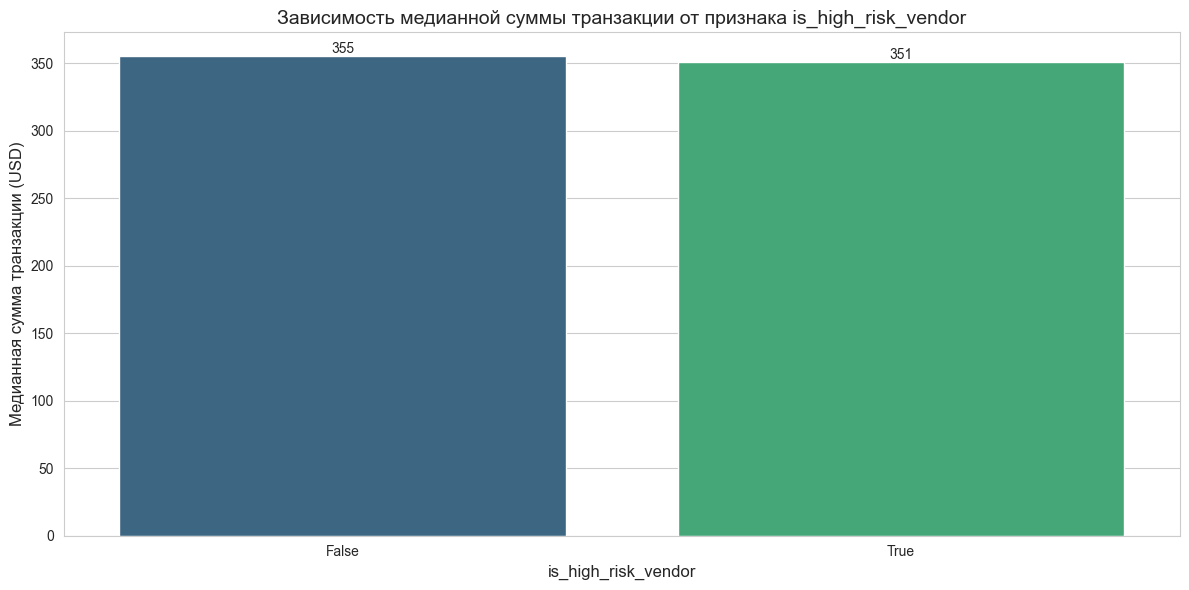

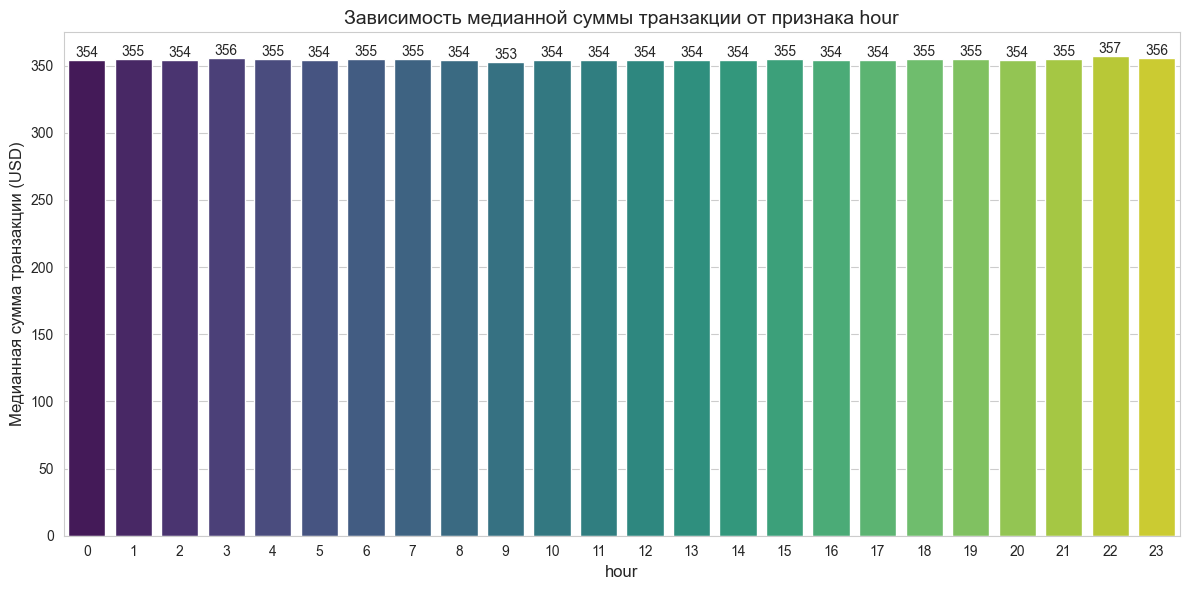

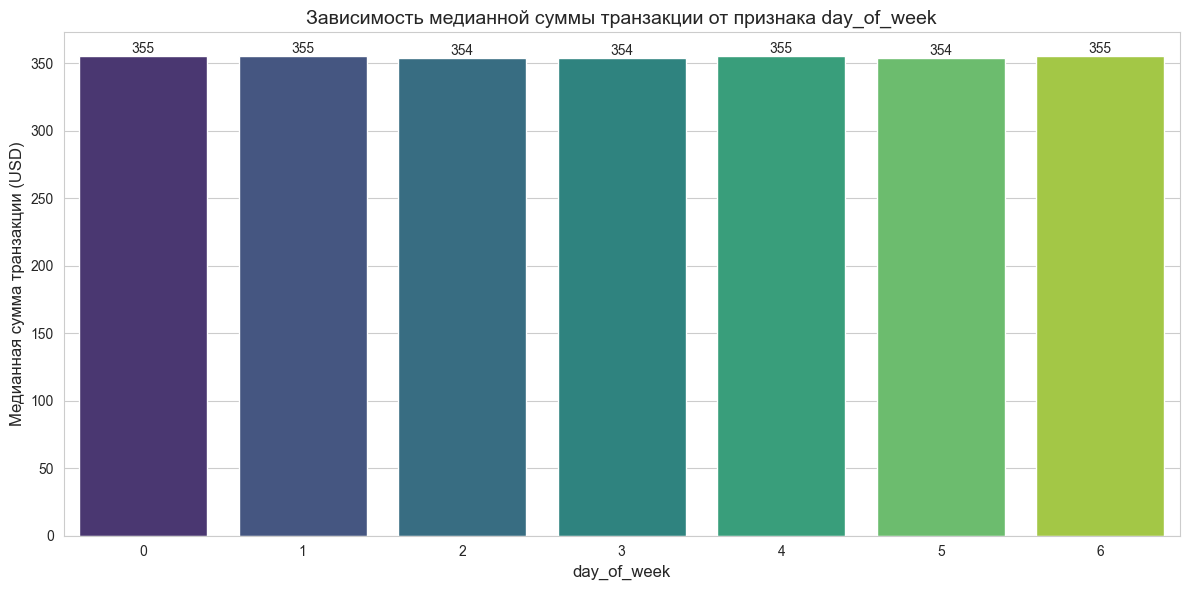

In [19]:
for feature in show_features:
    show_barplot_amount(feature)
    

Выше можно наблюдать, как люди тратят в разрезе различных признаков. Причем всё показано без влияния мошеннических транзакций.
# Выводы #
1) Сумма транзакции не зависит от времени, является ли категория вендора рискованной, канала проведения транзакции, города, девайса
2) Люди с типом карты "Platinum credit" намного больше тратят денег, чем люди с другими типами карты
3) Больше всего денег тратится на ритейл и путешествия
4) В большом городе люди тратятся больше
5) Нигерия сильно отстаёт от других стран по меркам трат людей

# Статистические тесты

#### Тест Уэлча

Первая гипотеза состоит в том, что суммы транзакции в мошеннических операциях в среднем больше сумм транзакции в легитимных.



Для проверки этой гипотезы будем использовать односторонний тест Уэлча с $\alpha = 0.05$

In [ ]:
first_group = df[df['is_fraud'] == True]['amount_usd']
second_group = df[df['is_fraud'] == False]['amount_usd']
st.ttest_ind(first_group, second_group, equal_var=False, alternative='greater')

p-value < $\alpha$ => отклоняем нулевую гипотезу, что значит подтверждения выдвинутой гипотезы